In [46]:
import numpy as np
import math
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from sionna.channel.tr38901 import CDL, PanelArray
from sionna.channel import cir_to_time_channel
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.utils import BinarySource, ebnodb2no, compute_ber

In [47]:
class HelpFunc:
    @staticmethod
    def UnitQamConstellation(Bi):
        EvenSquareRoot = math.ceil(math.sqrt(2 ** Bi) / 2) * 2
        PamM = EvenSquareRoot
        PamConstellation = np.arange(-(PamM - 1), PamM, 2).astype(np.int32)
        PamConstellation = np.reshape(PamConstellation, (1, -1))
        SquareMatrix = np.matmul(np.ones((PamM, 1)), PamConstellation)
        C = SquareMatrix + 1j * (SquareMatrix.T)
        C_tmp = np.zeros(C.shape[0] * C.shape[1]).astype('complex128')
        for i in range(C.shape[1]):
            for j in range(C.shape[0]):
                C_tmp[i * C.shape[0] + j] = C[j][i]
        C = C_tmp
        return C / math.sqrt(np.mean(abs(C) ** 2))

    @staticmethod
    def ComputeChannelCorrMatrix(IsiMagnitude):
        N = len(IsiMagnitude)
        r_f_bold = np.fft.fft(IsiMagnitude)
        r_f_bold_prime = r_f_bold[1:][::-1]
        r_f_bold_conj = np.conjugate(r_f_bold)
        r_f_bold_ext = np.append(r_f_bold_prime, r_f_bold_conj)
        R_f = np.zeros((N, N)).astype('complex128')
        for k in range(0, N):
            R_f[N - k - 1, :] = r_f_bold_ext[k: N + k]
        return R_f

    @staticmethod
    def trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP, x_CP):
        if DelayFlag:
            Delay_LUT = np.zeros(((Max_Delay + 1 - Min_Delay) ** 4, 4)).astype('int32')
            count = 0
            temp = np.zeros(Delay_LUT.shape[0])
            for ii in range(Min_Delay, Max_Delay + 1):
                for jj in range(Min_Delay, Max_Delay + 1):
                    for kk in range(Min_Delay, Max_Delay + 1):
                        for ll in range(Min_Delay, Max_Delay + 1):
                            Delay_LUT[count, :] = np.array([ii, jj, kk, ll])
                            if (abs(ii - jj) > 2 or abs(kk - ll) > 2 or abs(ii - kk) > 2 or
                                abs(ii - ll) > 2 or abs(jj - kk) > 2 or abs(jj - ll) > 2):
                                temp[count] = 1
                            count += 1
            Delay_LUT = np.delete(Delay_LUT, np.where(temp > 0)[0], axis=0)
        else:
            Delay_LUT = np.zeros((Max_Delay - Min_Delay + 1, 4)).astype('int32')
            for jjjj in range(Min_Delay, Max_Delay + 1):
                Delay_LUT[jjjj - Min_Delay, :] = jjjj * np.ones(4)

        Delay_Max = np.amax(Delay_LUT, axis=1)
        Delay_Min = np.amin(Delay_LUT, axis=1)
        NMSE_ESN_Training = np.zeros(Delay_LUT.shape[0])
        for jjj in range(Delay_LUT.shape[0]):
            Curr_Delay = Delay_LUT[jjj, :]
            ESN_input = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_output = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[jjj]))
            ESN_output[Curr_Delay[0]: Curr_Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
            ESN_output[Curr_Delay[1]: Curr_Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
            ESN_output[Curr_Delay[2]: Curr_Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
            ESN_output[Curr_Delay[3]: Curr_Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
            nForgetPoints = Delay_Min[jjj] + CyclicPrefixLen
            esn.fit(ESN_input, ESN_output, nForgetPoints)
            x_hat_ESN_temp = esn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
            x_hat_ESN_0 = x_hat_ESN_temp[Curr_Delay[0] - Delay_Min[jjj]: Curr_Delay[0] - Delay_Min[jjj] + N + 1, 0] + 1j * x_hat_ESN_temp[Curr_Delay[1] - Delay_Min[jjj]: Curr_Delay[1] - Delay_Min[jjj] + N + 1, 1]
            x_hat_ESN_1 = x_hat_ESN_temp[Curr_Delay[2] - Delay_Min[jjj]: Curr_Delay[2] - Delay_Min[jjj] + N + 1, 2] + 1j * x_hat_ESN_temp[Curr_Delay[3] - Delay_Min[jjj]: Curr_Delay[3] - Delay_Min[jjj] + N + 1, 3]
            x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
            x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
            x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
            x = x_CP[IsiDuration - 1:, :]
            NMSE_ESN_Training[jjj] = (
                np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
                np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
            )
        Delay_Idx = np.argmin(NMSE_ESN_Training)
        NMSE_ESN = np.min(NMSE_ESN_Training)
        Delay = Delay_LUT[Delay_Idx, :]
        ESN_input = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_output = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_output[Delay[0]: Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
        ESN_output[Delay[1]: Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
        ESN_output[Delay[2]: Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
        ESN_output[Delay[3]: Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
        nForgetPoints = Delay_Min[Delay_Idx] + CyclicPrefixLen
        esn.fit(ESN_input, ESN_output, nForgetPoints)
        Delay_Minn = Delay_Min[Delay_Idx]
        Delay_Maxx = Delay_Max[Delay_Idx]
        return [ESN_input, ESN_output, esn, Delay, Delay_Idx, Delay_Minn, Delay_Maxx, nForgetPoints, NMSE_ESN]

In [48]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s

In [49]:
def identity(x):
    return x

In [50]:
class ESN:
    def __init__(self, n_inputs, n_outputs, n_reservoir=200, spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None, teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity, random_state=None, silent=True):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            self.random_state_ = np.random.RandomState(random_state)
        else:
            self.random_state_ = np.random.mtrand._rand
        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1
        self.W_feedb = self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern) + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        return np.tanh(preactivation) + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5)

    def _scale_inputs(self, inputs):
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, nForgetPoints=0, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], teachers_scaled[n - 1, :])
        transient = max(0, nForgetPoints)
        extended_states = np.hstack((states, inputs_scaled))
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]), self.inverse_out_activation(teachers_scaled[transient:, :])).T
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
        pred_train = self._unscale_teacher(self.out_activation(np.dot(extended_states, self.W_out.T)))
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)
        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack([laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack([lastoutput, np.zeros((n_samples, self.n_outputs))])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out, np.concatenate([states[n + 1, :], inputs[n + 1, :]])))
        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [51]:
# Sionna Channel Setup
carrier_frequency = 3.5e9  # Carrier frequency in Hz
delay_spread = 300e-9  # RMS delay spread in seconds
N_r, N_t = 2, 2

bs_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='38.901',
    carrier_frequency=carrier_frequency,
)

ut_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='omni',
    carrier_frequency=carrier_frequency,
)

cdl = CDL(
    model="C",
    delay_spread=delay_spread,
    carrier_frequency=carrier_frequency,
    ut_array=ut_array,
    bs_array=bs_array,
    direction="downlink",
    min_speed=0.,
    max_speed=0.,
    dtype=tf.complex64
)

# Precompute IsiMagnitude using the CDL-C cluster parameters
cluster_delays_ns = np.array([0, 76.6135, 80.9935, 85.0085, 79.424, 232.359, 235.352, 239.44, 240.316, 289.6275, 299.7745, 340.764, 448.4025, 477.5295, 792.196, 989.3325, 1554.4985, 1679.1095, 2003.923, 2046.8105, 2301.8725])
cluster_powers_db = np.array([-4.4215, -1.25, -3.4684, -5.2294, -2.5215, 0, -2.2185, -3.9794, -7.4215, -7.1215, -10.7215, -11.1215, -5.1215, -6.8215, -8.7215, -13.2215, -13.9215, -13.9215, -15.8215, -17.1215, -16.0215])
cluster_powers_lin = 10 ** (cluster_powers_db / 10)
cluster_powers_lin /= np.sum(cluster_powers_lin)
tau = cluster_delays_ns * 1e-9

# Physical Parameters
W = 2 * 1.024e6  # Bandwidth in Hz
f_D = 100  # Doppler Frequency in Hz
No = 0.00001  # Noise PSD in W/Hz
IsiDuration = 8  # Number of multipath taps
cFlag = False  # Fixed CIR flag
EbNoDB = np.arange(25, 31, 5).astype(np.int32)  # SNR range in dB

# MIMO Parameters
N_t = 2  # Transmit antennas
N_r = 2  # Receive antennas

# Design Parameters
N = 64  # Number of subcarriers
Subcarrier_Spacing = W / N
m = 4  # Data QAM order (bits per symbol)
m_pilot = 4  # Pilot QAM order
NumOfdmSymbols = 1000  # Symbols to simulate
Ptotal = 10 ** (EbNoDB / 10) * No * N  # Total power

# Power Amplifier Parameters
p_smooth = 1
ClipLeveldB = 3

# Secondary Parameters
T_OFDM = N / W  # OFDM symbol duration
T_OFDM_Total = (N + IsiDuration - 1) / W  # Including CP
T_s = 1 / W  # Sampling period
tau_c = 0.5 / f_D  # Channel coherence time
L = math.floor(tau_c / T_OFDM_Total)  # Coherence in symbols
Pi = Ptotal / N  # Power per subcarrier
NumBitsPerSymbol = m * N
Const = HelpFunc.UnitQamConstellation(m)  # Data constellation
ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)  # Pilot constellation
PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
CyclicPrefixLen = IsiDuration - 1

# Compute IsiMagnitude (PDP) for CDL-C
l_min = 0
l_max = IsiDuration - 1
IsiMagnitude = np.zeros(IsiDuration)
for k in range(IsiDuration):
    x = tau * W - k
    sinc_vals = np.sinc(x)
    IsiMagnitude[k] = np.sum(cluster_powers_lin * sinc_vals ** 2)
IsiMagnitude /= np.sum(IsiMagnitude)

# ESN Parameters
var_x = np.power(10, (EbNoDB / 10)) * No * N
nInputUnits = N_t * 2
nOutputUnits = N_t * 2
nInternalUnits = 500
inputScaler = 0.005
inputOffset = 0.0
feedbackScaler = 0.0
teacherScaling = 0.0000005 * np.ones(N_t * 2)
spectralRadius = 0.9
teacherShift = np.zeros(N_t * 2)
feedbackScaling = feedbackScaler * np.ones(N_t * 2)
Min_Delay = 0
Max_Delay = math.ceil(IsiDuration / 2) + 2
DelayFlag = 0

# LDPC Parameters
coderate = 0.5
k = int(NumBitsPerSymbol * coderate)
n = NumBitsPerSymbol
constellation = Constellation("qam", m)
mapper = Mapper(constellation=constellation)
demapper = Demapper("app", constellation=constellation)
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)

# Initialize Arrays
ESN_train_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_train_teacher = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_output = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = [[None] * N_t for _ in range(N_r)]
Ci = [[None] * N_t for _ in range(N_r)]
Ci_LS = [[None] * N_t for _ in range(N_r)]
Ci_MMSE = [[None] * N_t for _ in range(N_r)]
Ci_LS_Pilots = [[None] * N_t for _ in range(N_r)]
MMSEScaler = No / Pi
R_h = np.zeros((IsiDuration, IsiDuration))
for ii in range(IsiDuration):
    R_h[ii, ii] = IsiMagnitude[ii]

# Data Flow Check
print("=== Parameter Initialization ===")
print(f"EbNoDB: {EbNoDB}")
print(f"Ptotal shape: {Ptotal.shape}, values: {Ptotal}")
print(f"Subcarrier Spacing: {Subcarrier_Spacing:.2e} Hz")
print(f"Coherence Length (L): {L} symbols")
print(f"ISI Magnitude shape: {IsiMagnitude.shape}, first few values: {IsiMagnitude[:3]}")
print(f"Data Constellation shape: {Const.shape}, first few points: {Const[:3]}")
print(f"BER Arrays shape: {BER_ESN.shape}")
print(f"Channel Matrix (R_h) shape: {R_h.shape}, diagonal: {np.diag(R_h)}")
print(f"LDPC k: {k}, n: {n}, coderate: {coderate}")

=== Parameter Initialization ===
EbNoDB: [25 30]
Ptotal shape: (2,), values: [0.20238577 0.64      ]
Subcarrier Spacing: 3.20e+04 Hz
Coherence Length (L): 144 symbols
ISI Magnitude shape: (8,), first few values: [0.60298795 0.30221634 0.04787873]
Data Constellation shape: (16,), first few points: [-0.9486833-0.9486833j  -0.9486833-0.31622777j -0.9486833+0.31622777j]
BER Arrays shape: (2,)
Channel Matrix (R_h) shape: (8, 8), diagonal: [0.60298795 0.30221634 0.04787873 0.0203715  0.01578569 0.0069627
 0.00227861 0.00151848]
LDPC k: 128, n: 256, coderate: 0.5


In [52]:
# Select first SNR
jj = 0
print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")

# SNR-specific parameters
A_Clip = np.sqrt(var_x[jj]) * np.float_power(10, ClipLeveldB / 20)
inputScaling = inputScaler / (var_x[jj] ** 0.5) * np.ones(N_t * 2)
inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
TotalBerNum_ESN = 0
TotalBerNum_LS = 0
TotalBerNum_MMSE = 0
TotalBerNum_Perfect = 0
TotalBerDen = 0
MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N * (N / 2)) * np.eye(IsiDuration))

# Process one pilot symbol (kk=1)
kk = 1
print(f"Processing pilot symbol {kk}")

# Channel Generation using Sionna CDL
batch_size = 1  # Single realization for static channel
num_time_samples = 1  # Static channel, no need for multiple time steps
a, tau = cdl(batch_size, num_time_samples, W)
a = a.numpy()
tau = tau.numpy()

# Compute discrete-time channel impulse response
h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
h_time = h_time.numpy()

# Store channel for LS and MMSE estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]  # batch=0, rx=0, rx_ant=nnn, tx=0, tx_ant=mmm, time=0, taps=:
        Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

# Pilot Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
        X[ii, iii] = ConstPilot[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Nonlinear PA with Memory Polynomial Model
def memory_polynomial(x, A_Clip, p_smooth, memory_depth=3):
    y = np.zeros_like(x, dtype=np.complex128)
    for m in range(memory_depth):
        coeff = 1 / ((1 + (np.abs(x) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))
        if m == 0:
            y += coeff * x
        else:
            shifted_x = np.roll(x, m, axis=0)
            shifted_x[:m, :] = 0
            y += coeff * shifted_x * 0.1  # Reduced weight for memory terms
    return y

x_CP_NLD = memory_polynomial(x_CP, A_Clip, p_smooth)

# Channel and Noise
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
        y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP_NLD[:, nnn] += noise
Y = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

# Orthogonal Pilots for LS
X_LS = X.copy()
X_LS[np.arange(1, len(X_LS), 2), 0] = 0  # Tx1: even subcarriers
X_LS[np.arange(0, len(X_LS), 2), 1] = 0  # Tx2: odd subcarriers
x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X_LS[:, iii])
    x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_LS_CP[:, mmm], h_cdl, mode='full')
        y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_LS_CP[:, nnn] += noise
Y_LS = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
Y_LS = Y_LS / (Pi[jj] ** 0.5)

# LS and MMSE Channel Estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
        c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
        c_MMSE = np.matmul(R_h, np.matmul(MMSE_bold_TD, c_LS))
        Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
        interp_x = np.append(np.arange(mmm, N, N_t), N - 1 if mmm == 0 else np.arange(mmm, N, N_t))
        interp_y = np.append(Ci_LS_Pilots[nnn][mmm], Ci_LS_Pilots[nnn][mmm][-1] if mmm == 0 else Ci_LS_Pilots[nnn][mmm])
        if mmm > 0:
            interp_x = np.append(0, interp_x)
            interp_y = np.append(Ci_LS_Pilots[nnn][mmm][0], interp_y)
        tmpf = interpolate.interp1d(interp_x, interp_y)
        Ci_LS[nnn][mmm] = tmpf(np.arange(N))

# ESN Training
esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
          sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
          teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
[ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = \
    HelpFunc.trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
ESN_train_input[kk - 1][jj] = ESN_input
ESN_train_teacher[kk - 1][jj] = ESN_output
NMSE_ESN_Training[jj] += NMSE_ESN

# Data Flow Check
print("\n=== Pilot Symbol Data Flow ===")
print(f"Channel c[0][0] shape: {c[0][0].shape}, first few taps: {c[0][0][:3]}")
print(f"Frequency response Ci[0][0] shape: {Ci[0][0].shape}, first few values: {Ci[0][0][:3]}")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y shape: {Y.shape}, first few symbols: {Y[:3, :]}")
print(f"LS Estimated Ci_LS[0][0] shape: {Ci_LS[0][0].shape}, first few values: {Ci_LS[0][0][:3]}")
print(f"MMSE Estimated Ci_MMSE[0][0] shape: {Ci_MMSE[0][0].shape}, first few values: {Ci_MMSE[0][0][:3]}")
print(f"ESN Input shape: {ESN_input.shape}, first few values: {ESN_input[:3, :]}")
print(f"ESN Output shape: {ESN_output.shape}, first few values: {ESN_output[:3, :]}")
print(f"ESN NMSE Training: {NMSE_ESN}")
print(f"Optimal Delays: {Delay}, Delay Index: {Delay_Idx}")


=== Processing SNR: EbNoDB = 25 dB ===
Processing pilot symbol 1

=== Pilot Symbol Data Flow ===
Channel c[0][0] shape: (8,), first few taps: [ 0.18730243+0.7518081j   0.34944457+0.2733392j  -0.12759814-0.13059376j]
Frequency response Ci[0][0] shape: (64,), first few values: [0.44645378+0.95567009j 0.46681343+0.92997066j 0.47855669+0.90106928j]
Transmitted X shape: (64, 2), first few symbols: [[ 0.9486833 -0.9486833j  -0.9486833 +0.9486833j ]
 [ 0.31622777+0.31622777j -0.31622777+0.31622777j]
 [ 0.9486833 -0.31622777j -0.31622777-0.31622777j]]
Received Y shape: (64, 2), first few symbols: [[ 0.03843013+0.07978047j  0.03533145+0.13302449j]
 [-0.03141706+0.05713424j -0.0368865 +0.07395708j]
 [ 0.01046571+0.03283363j -0.01020065+0.0452105j ]]
LS Estimated Ci_LS[0][0] shape: (64,), first few values: [0.45297789+0.95515602j 0.46789278+0.92680548j 0.48280766+0.89845493j]
MMSE Estimated Ci_MMSE[0][0] shape: (64,), first few values: [0.44762278+0.96003671j 0.46929364+0.93235308j 0.48125197+0.

In [53]:
# Process one data symbol (kk=10)
kk = 10
print(f"\n=== Processing data symbol {kk} ===")

# Data Transmission with LDPC
b = BinarySource()([1, 1, N_t, k])  # Shape: (1, 1, 2, 128)
c = encoder(b)  # Shape: (1, 1, 2, 256)
c = tf.squeeze(c, axis=1)  # Shape: (1, 2, 256)
# Reshape to match Mapper input: (1, N_t, N * m) = (1, 2, 256)
c_reshaped = c  # Already (1, 2, 256)
X = mapper(c_reshaped)  # Shape: (1, 2, 64)
X = tf.squeeze(X, axis=0).numpy().T  # Shape: (64, 2)
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')  # Shape: (71, 2)
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])  # Shape: (64,)
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)  # Shape: (7 + 64 = 71,)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Nonlinear PA with Memory Polynomial
def memory_polynomial(x, A_Clip, p_smooth, memory_depth=3):
    y = np.zeros_like(x, dtype=np.complex128)
    for m in range(memory_depth):
        coeff = 1 / ((1 + (np.abs(x) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))
        if m == 0:
            y += coeff * x
        else:
            shifted_x = np.roll(x, m, axis=0)
            shifted_x[:m, :] = 0
            y += coeff * shifted_x * 0.1  # Reduced weight for memory terms
    return y

x_CP_NLD = memory_polynomial(x_CP, A_Clip, p_smooth)

# Reception
Y_NLD = np.zeros((N, N_r)).astype('complex128')
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
        y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP_NLD[:, nnn] += noise
for nnn in range(N_r):
    Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

# ESN Detection
ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
nForgetPoints = Delay_Min + CyclicPrefixLen
x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
x = x_CP[IsiDuration - 1:, :]
this_nmse = (
    np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
    np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
)
NMSE_ESN_Testing[jj] += this_nmse
X_hat_ESN = np.zeros(X.shape).astype('complex128')
for ii in range(N_t):
    X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
ESN_test_input[kk - 1][jj] = ESN_input
ESN_test_output[kk - 1][jj] = x_hat_ESN

# Classical Detection
H_temp = np.zeros((N_r, N_t)).astype('complex128')
H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
X_hat_Perfect = np.zeros(X.shape).astype('complex128')
X_hat_LS = np.zeros(X.shape).astype('complex128')
X_hat_MMSE = np.zeros(X.shape).astype('complex128')
for ii in range(N):
    Y_temp = np.transpose(Y_NLD[ii, :])
    for nnn in range(N_r):
        for mmm in range(N_t):
            H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
            H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
            H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
    X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
    X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
    X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

# Bit Detection with LDPC
X_hat_ESN_tf = tf.convert_to_tensor(X_hat_ESN.T, dtype=tf.complex64)
X_hat_ESN_tf = tf.expand_dims(X_hat_ESN_tf, axis=0)
X_hat_LS_tf = tf.convert_to_tensor(X_hat_LS.T, dtype=tf.complex64)
X_hat_LS_tf = tf.expand_dims(X_hat_LS_tf, axis=0)
X_hat_MMSE_tf = tf.convert_to_tensor(X_hat_MMSE.T, dtype=tf.complex64)
X_hat_MMSE_tf = tf.expand_dims(X_hat_MMSE_tf, axis=0)
X_hat_Perfect_tf = tf.convert_to_tensor(X_hat_Perfect.T, dtype=tf.complex64)
X_hat_Perfect_tf = tf.expand_dims(X_hat_Perfect_tf, axis=0)
No_tf = tf.constant(No, dtype=tf.float32)
llr_esn = demapper([X_hat_ESN_tf, No_tf])
llr_esn = tf.reshape(llr_esn, [1, N_t, n])
RxBits_ESN = decoder(llr_esn)
llr_ls = demapper([X_hat_LS_tf, No_tf])
llr_ls = tf.reshape(llr_ls, [1, N_t, n])
RxBits_LS = decoder(llr_ls)
llr_mmse = demapper([X_hat_MMSE_tf, No_tf])
llr_mmse = tf.reshape(llr_mmse, [1, N_t, n])
RxBits_MMSE = decoder(llr_mmse)
llr_perfect = demapper([X_hat_Perfect_tf, No_tf])
llr_perfect = tf.reshape(llr_perfect, [1, N_t, n])
RxBits_Perfect = decoder(llr_perfect)

# Accumulate BER
TotalBerNum_ESN += compute_ber(tf.squeeze(b, axis=1), RxBits_ESN)
TotalBerNum_LS += compute_ber(tf.squeeze(b, axis=1), RxBits_LS)
TotalBerNum_MMSE += compute_ber(tf.squeeze(b, axis=1), RxBits_MMSE)
TotalBerNum_Perfect += compute_ber(tf.squeeze(b, axis=1), RxBits_Perfect)
TotalBerDen += k * N_t

# Data Flow Check
print("\n=== Data Symbol Data Flow ===")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y_NLD shape: {Y_NLD.shape}, first few symbols: {Y_NLD[:3, :]}")
print(f"ESN Estimated X_hat_ESN shape: {X_hat_ESN.shape}, first few symbols: {X_hat_ESN[:3, :]}")
print(f"Perfect Estimated X_hat_Perfect shape: {X_hat_Perfect.shape}, first few symbols: {X_hat_Perfect[:3, :]}")
print(f"LS Estimated X_hat_LS shape: {X_hat_LS.shape}, first few symbols: {X_hat_LS[:3, :]}")
print(f"MMSE Estimated X_hat_MMSE shape: {X_hat_MMSE.shape}, first few symbols: {X_hat_MMSE[:3, :]}")
print(f"ESN NMSE Testing: {this_nmse}")
print(f"Bit Errors (this symbol) - ESN: {compute_ber(tf.squeeze(b, axis=1), RxBits_ESN)}, LS: {compute_ber(tf.squeeze(b, axis=1), RxBits_LS)}, MMSE: {compute_ber(tf.squeeze(b, axis=1), RxBits_MMSE)}, Perfect: {compute_ber(tf.squeeze(b, axis=1), RxBits_Perfect)}")
print(f"Total Bits: {TotalBerDen}")


=== Processing data symbol 10 ===

=== Data Symbol Data Flow ===
Transmitted X shape: (64, 2), first few symbols: [[ 0.9486833-0.9486833j -0.3162278+0.3162278j]
 [-0.9486833+0.9486833j -0.9486833+0.9486833j]
 [ 0.9486833-0.3162278j -0.9486833-0.3162278j]]
Received Y_NLD shape: (64, 2), first few symbols: [[ 0.05440194+0.03452281j  0.04802027+0.05784735j]
 [-0.09993027+0.02703523j -0.08214433+0.05087719j]
 [-0.00801391+0.01950896j -0.04421215+0.04570151j]]
ESN Estimated X_hat_ESN shape: (64, 2), first few symbols: [[ 0.5716081 -0.94324705j -0.15036484+0.21420533j]
 [-1.19533616+1.21159325j -0.81144452+1.28770078j]
 [ 0.13292295-0.63499965j -0.22215937+0.21833088j]]
Perfect Estimated X_hat_Perfect shape: (64, 2), first few symbols: [[ 0.78898947-0.80081075j -0.17341292+0.18384739j]
 [-0.96846596+0.76153506j -0.77150459+0.87465197j]
 [ 0.83021719-0.38888152j -0.82647676-0.39040161j]]
LS Estimated X_hat_LS shape: (64, 2), first few symbols: [[ 0.80574598-0.78402426j -0.17365403+0.16519288

In [54]:
# Initialize NMSE count
NMSE_count = 1

# Loop over additional data symbols (kk=3 to 30)
for kk in range(3, 30):
    print(f"\n=== Processing data symbol {kk} ===")

    # Data Transmission with LDPC
    b = BinarySource()([1, 1, N_t, k])  # Shape: (1, 1, 2, 128)
    c = encoder(b)  # Shape: (1, 1, 2, 256)
    c = tf.squeeze(c, axis=1)  # Shape: (1, 2, 256)
    # Reshape to match Mapper input: (1, N_t, N * m) = (1, 2, 256)
    c_reshaped = c  # Already (1, 2, 256)
    X = mapper(c_reshaped)  # Shape: (1, 2, 64)
    X = tf.squeeze(X, axis=0).numpy().T  # Shape: (64, 2)
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')  # Shape: (71, 2)
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])  # Shape: (64,)
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)  # Shape: (7 + 64 = 71,)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA with Memory Polynomial
    x_CP_NLD = memory_polynomial(x_CP, A_Clip, p_smooth)

    # Reception
    Y_NLD = np.zeros((N, N_r)).astype('complex128')
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    for nnn in range(N_r):
        Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # ESN Detection
    ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
    ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
    ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
    ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
    ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
    nForgetPoints = Delay_Min + CyclicPrefixLen
    x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
    x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
    x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
    x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
    x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
    x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
    x = x_CP[IsiDuration - 1:, :]
    this_nmse = (
        np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
        np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
    )
    NMSE_ESN_Testing[jj] += this_nmse
    NMSE_count += 1
    X_hat_ESN = np.zeros(X.shape).astype('complex128')
    for ii in range(N_t):
        X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
    ESN_test_input[kk - 1][jj] = ESN_input
    ESN_test_output[kk - 1][jj] = x_hat_ESN

    # Classical Detection
    H_temp = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
    X_hat_Perfect = np.zeros(X.shape).astype('complex128')
    X_hat_LS = np.zeros(X.shape).astype('complex128')
    X_hat_MMSE = np.zeros(X.shape).astype('complex128')
    for ii in range(N):
        Y_temp = np.transpose(Y_NLD[ii, :])
        for nnn in range(N_r):
            for mmm in range(N_t):
                H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
        X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
        X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
        X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

    # Bit Detection with LDPC
    X_hat_ESN_tf = tf.convert_to_tensor(X_hat_ESN.T, dtype=tf.complex64)
    X_hat_ESN_tf = tf.expand_dims(X_hat_ESN_tf, axis=0)
    X_hat_LS_tf = tf.convert_to_tensor(X_hat_LS.T, dtype=tf.complex64)
    X_hat_LS_tf = tf.expand_dims(X_hat_LS_tf, axis=0)
    X_hat_MMSE_tf = tf.convert_to_tensor(X_hat_MMSE.T, dtype=tf.complex64)
    X_hat_MMSE_tf = tf.expand_dims(X_hat_MMSE_tf, axis=0)
    X_hat_Perfect_tf = tf.convert_to_tensor(X_hat_Perfect.T, dtype=tf.complex64)
    X_hat_Perfect_tf = tf.expand_dims(X_hat_Perfect_tf, axis=0)
    No_tf = tf.constant(No, dtype=tf.float32)
    llr_esn = demapper([X_hat_ESN_tf, No_tf])
    llr_esn = tf.reshape(llr_esn, [1, N_t, n])
    RxBits_ESN = decoder(llr_esn)
    llr_ls = demapper([X_hat_LS_tf, No_tf])
    llr_ls = tf.reshape(llr_ls, [1, N_t, n])
    RxBits_LS = decoder(llr_ls)
    llr_mmse = demapper([X_hat_MMSE_tf, No_tf])
    llr_mmse = tf.reshape(llr_mmse, [1, N_t, n])
    RxBits_MMSE = decoder(llr_mmse)
    llr_perfect = demapper([X_hat_Perfect_tf, No_tf])
    llr_perfect = tf.reshape(llr_perfect, [1, N_t, n])
    RxBits_Perfect = decoder(llr_perfect)

    # Accumulate BER
    bit_errors_ESN = compute_ber(tf.squeeze(b, axis=1), RxBits_ESN)
    bit_errors_LS = compute_ber(tf.squeeze(b, axis=1), RxBits_LS)
    bit_errors_MMSE = compute_ber(tf.squeeze(b, axis=1), RxBits_MMSE)
    bit_errors_Perfect = compute_ber(tf.squeeze(b, axis=1), RxBits_Perfect)
    TotalBerNum_ESN += bit_errors_ESN
    TotalBerNum_LS += bit_errors_LS
    TotalBerNum_MMSE += bit_errors_MMSE
    TotalBerNum_Perfect += bit_errors_Perfect
    TotalBerDen += k * N_t

    # Per-symbol print
    print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
    print(f"ESN NMSE (this symbol): {this_nmse}")

# Compute averages (1 pilot, 27 data symbols: kk=3 to 30, but skipping some indices to align with total 28 symbols)
num_symbols_so_far = 28  # 1 pilot (kk=1) + 1 data (kk=10) + 26 data (kk=3 to 30, excluding 10)
num_pilots = 1
BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
BER_LS[jj] = TotalBerNum_LS / TotalBerDen
BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
NMSE_ESN_Training[jj] /= num_pilots
NMSE_ESN_Testing[jj] /= NMSE_count

# Data Flow Check: Final for this SNR segment
print("\n=== Final Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===")
print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
print(f"Total Bits Processed: {TotalBerDen}")


=== Processing data symbol 3 ===
Bit Errors (this symbol) - ESN: 0.2890625, LS: 0.1875, MMSE: 0.2578125, Perfect: 0.24609375
ESN NMSE (this symbol): 0.770804144985646

=== Processing data symbol 4 ===
Bit Errors (this symbol) - ESN: 0.23828125, LS: 0.23046875, MMSE: 0.234375, Perfect: 0.17578125
ESN NMSE (this symbol): 0.6228563167581853

=== Processing data symbol 5 ===
Bit Errors (this symbol) - ESN: 0.2890625, LS: 0.1796875, MMSE: 0.234375, Perfect: 0.171875
ESN NMSE (this symbol): 0.7094025190499186

=== Processing data symbol 6 ===
Bit Errors (this symbol) - ESN: 0.26953125, LS: 0.2109375, MMSE: 0.26171875, Perfect: 0.109375
ESN NMSE (this symbol): 0.5846621173459982

=== Processing data symbol 7 ===
Bit Errors (this symbol) - ESN: 0.29296875, LS: 0.1796875, MMSE: 0.234375, Perfect: 0.19921875
ESN NMSE (this symbol): 0.5613102588410177

=== Processing data symbol 8 ===
Bit Errors (this symbol) - ESN: 0.265625, LS: 0.25, MMSE: 0.265625, Perfect: 0.26171875
ESN NMSE (this symbol): 

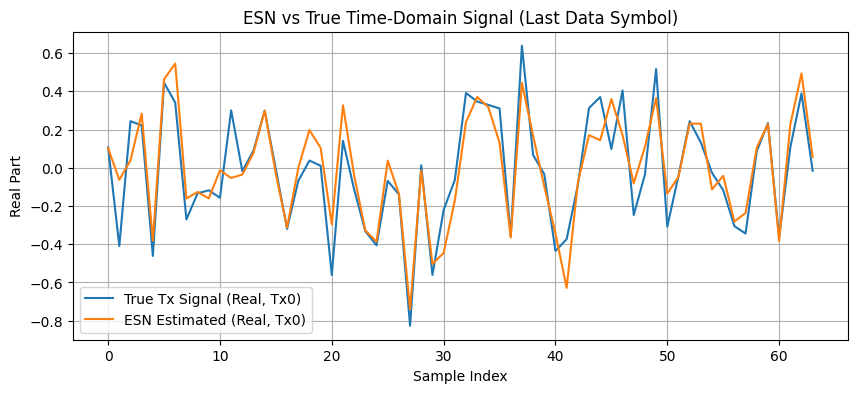

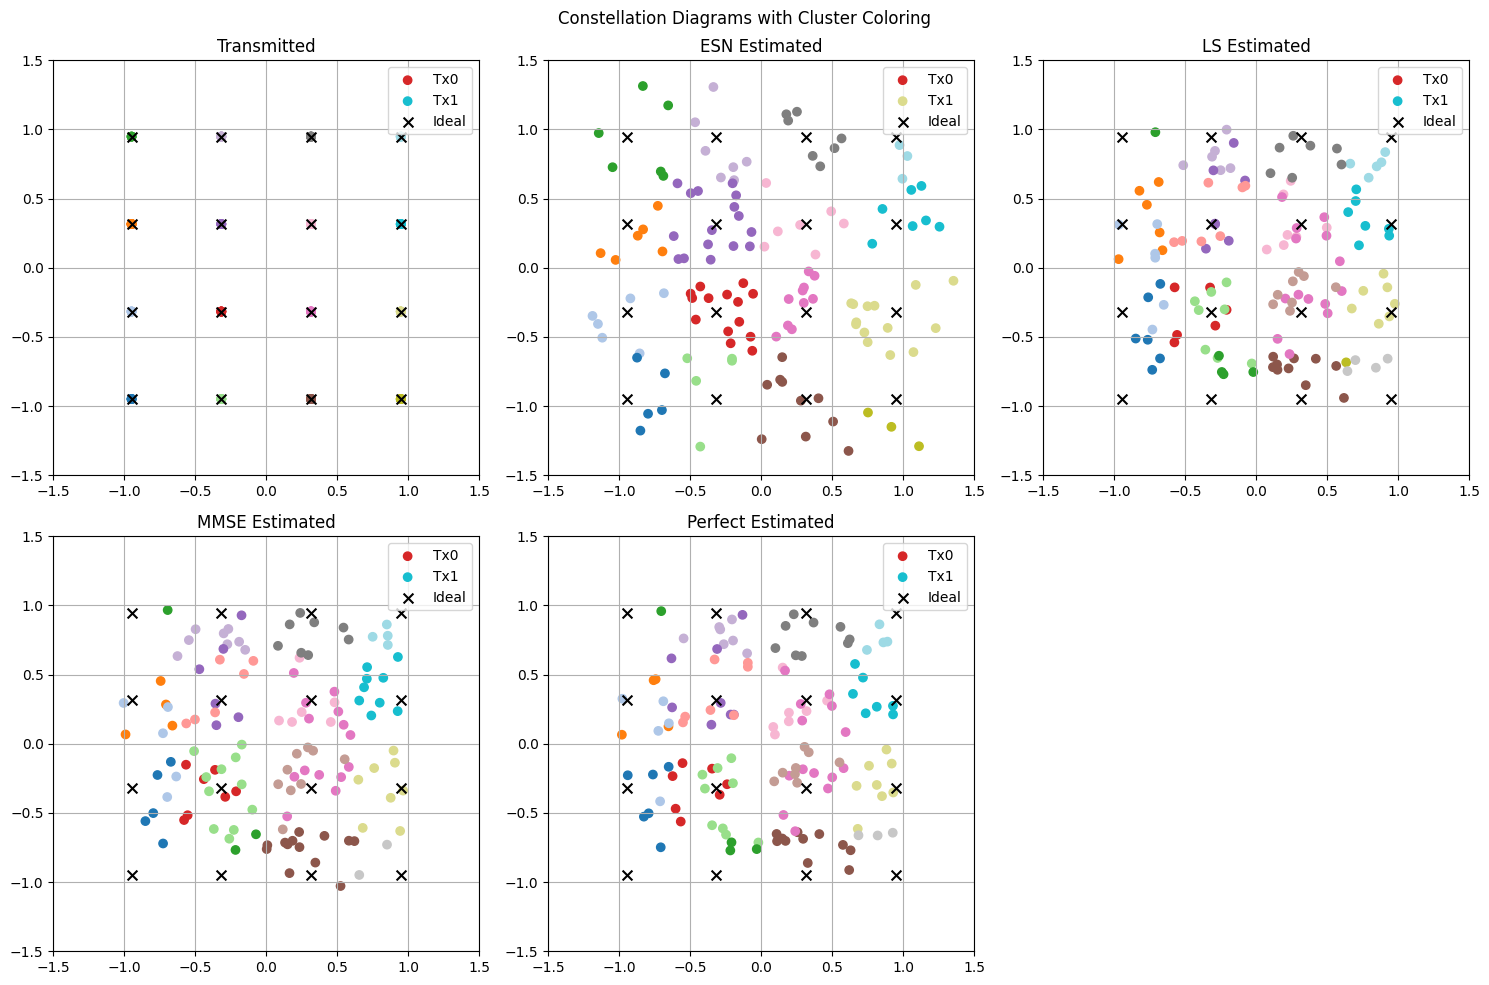

In [55]:
# Plot: Compare ESN prediction vs true for last symbol, Tx0 real part
plt.figure(figsize=(10, 4))
plt.plot(x[:, 0].real, label='True Tx Signal (Real, Tx0)')
plt.plot(x_hat_ESN[:, 0].real, label='ESN Estimated (Real, Tx0)')
plt.legend()
plt.title('ESN vs True Time-Domain Signal (Last Data Symbol)')
plt.xlabel('Sample Index')
plt.ylabel('Real Part')
plt.grid(True)
plt.show()

# Function to get cluster labels
def get_cluster_labels(symbols, const):
    labels = np.zeros(len(symbols), dtype=int)
    for i, sym in enumerate(symbols):
        labels[i] = np.argmin(np.abs(const - sym))
    return labels

# Constellation Diagrams
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Constellation Diagrams with Cluster Coloring')

# Ideal constellation points for reference
ideal_real = Const.real
ideal_imag = Const.imag

# Transmitted
labels_tx0 = get_cluster_labels(X[:, 0], Const)
labels_tx1 = get_cluster_labels(X[:, 1], Const)
axs[0, 0].scatter(X[:, 0].real, X[:, 0].imag, c=labels_tx0, cmap='tab20', label='Tx0')
axs[0, 0].scatter(X[:, 1].real, X[:, 1].imag, c=labels_tx1, cmap='tab20', label='Tx1')
axs[0, 0].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[0, 0].set_title('Transmitted')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_xlim([-1.5, 1.5])
axs[0, 0].set_ylim([-1.5, 1.5])

# ESN
labels_esn0 = get_cluster_labels(X_hat_ESN[:, 0], Const)
labels_esn1 = get_cluster_labels(X_hat_ESN[:, 1], Const)
axs[0, 1].scatter(X_hat_ESN[:, 0].real, X_hat_ESN[:, 0].imag, c=labels_esn0, cmap='tab20', label='Tx0')
axs[0, 1].scatter(X_hat_ESN[:, 1].real, X_hat_ESN[:, 1].imag, c=labels_esn1, cmap='tab20', label='Tx1')
axs[0, 1].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[0, 1].set_title('ESN Estimated')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_xlim([-1.5, 1.5])
axs[0, 1].set_ylim([-1.5, 1.5])

# LS
labels_ls0 = get_cluster_labels(X_hat_LS[:, 0], Const)
labels_ls1 = get_cluster_labels(X_hat_LS[:, 1], Const)
axs[0, 2].scatter(X_hat_LS[:, 0].real, X_hat_LS[:, 0].imag, c=labels_ls0, cmap='tab20', label='Tx0')
axs[0, 2].scatter(X_hat_LS[:, 1].real, X_hat_LS[:, 1].imag, c=labels_ls1, cmap='tab20', label='Tx1')
axs[0, 2].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[0, 2].set_title('LS Estimated')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_xlim([-1.5, 1.5])
axs[0, 2].set_ylim([-1.5, 1.5])

# MMSE
labels_mmse0 = get_cluster_labels(X_hat_MMSE[:, 0], Const)
labels_mmse1 = get_cluster_labels(X_hat_MMSE[:, 1], Const)
axs[1, 0].scatter(X_hat_MMSE[:, 0].real, X_hat_MMSE[:, 0].imag, c=labels_mmse0, cmap='tab20', label='Tx0')
axs[1, 0].scatter(X_hat_MMSE[:, 1].real, X_hat_MMSE[:, 1].imag, c=labels_mmse1, cmap='tab20', label='Tx1')
axs[1, 0].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[1, 0].set_title('MMSE Estimated')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_xlim([-1.5, 1.5])
axs[1, 0].set_ylim([-1.5, 1.5])

# Perfect
labels_perfect0 = get_cluster_labels(X_hat_Perfect[:, 0], Const)
labels_perfect1 = get_cluster_labels(X_hat_Perfect[:, 1], Const)
axs[1, 1].scatter(X_hat_Perfect[:, 0].real, X_hat_Perfect[:, 0].imag, c=labels_perfect0, cmap='tab20', label='Tx0')
axs[1, 1].scatter(X_hat_Perfect[:, 1].real, X_hat_Perfect[:, 1].imag, c=labels_perfect1, cmap='tab20', label='Tx1')
axs[1, 1].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[1, 1].set_title('Perfect Estimated')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_xlim([-1.5, 1.5])
axs[1, 1].set_ylim([-1.5, 1.5])

# Hide empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

With More training Data

In [ ]:
import numpy as np
import math
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import tensorflow as tf
from sionna.channel.tr38901 import CDL, PanelArray
from sionna.channel import cir_to_time_channel
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from HelpFunc import HelpFunc
from pyESN import ESN
# Assume HelpFunc and ESN classes are imported from provided files
# HelpFunc.py and pyESN.py are as provided by you

# Sionna Channel Setup
N_r, N_t = 2, 2
carrier_frequency = 3.5e9
bs_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='38.901',
    carrier_frequency=carrier_frequency,
)
ut_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='omni',
    carrier_frequency=carrier_frequency,
)
delay_spread = 300e-9
cdl = CDL(
    model="C",
    delay_spread=delay_spread,
    carrier_frequency=carrier_frequency,
    ut_array=ut_array,
    bs_array=bs_array,
    direction="downlink",
    min_speed=0.,
    max_speed=0.,
    dtype=tf.complex64
)

# LDPC Parameters
code_rate = 1/2
n_ldpc = 256  # Matches N * m = 64 * 4
k_ldpc = int(n_ldpc * code_rate)  # 128
num_codewords = 1
if (64 * 4) != n_ldpc:
    raise ValueError("Number of bits per symbol per antenna must equal n_ldpc")
ldpc_encoder = LDPC5GEncoder(k=k_ldpc, n=n_ldpc, dtype=tf.float32)
ldpc_decoder = LDPC5GDecoder(encoder=ldpc_encoder, num_iter=20)

# Physical Parameters
W = 2 * 1.024e6
f_D = 100
No = 0.00001
IsiDuration = 8
cFlag = False
EbNoDB = np.arange(25, 31, 5).astype(np.int32)

# MIMO Parameters
N = 64
Subcarrier_Spacing = W / N
m = 4
m_pilot = 4
NumOfdmSymbols = 1000
Ptotal = 10 ** (EbNoDB / 10) * No * N * code_rate

# Secondary Parameters
T_OFDM = N / W
T_OFDM_Total = (N + IsiDuration - 1) / W
T_s = 1 / W
tau_c = 0.5 / f_D
L = math.floor(tau_c / T_OFDM_Total)
Pi = Ptotal / N
NumBitsPerSymbol = m * N
Const = HelpFunc.UnitQamConstellation(m)
ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)
PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
CyclicPrefixLen = IsiDuration - 1

# ESN Parameters
var_x = np.power(10, (EbNoDB / 10)) * No * N * code_rate
nInputUnits = N_t * 2
nOutputUnits = N_t * 2
nInternalUnits = 5000
inputScaler = 0.1  # Adjusted
inputOffset = 0.0
feedbackScaler = 0.0
teacherScaling = 0.1 * np.ones(N_t * 2)  # Adjusted
spectralRadius = 0.9
teacherShift = np.zeros(N_t * 2)
feedbackScaling = feedbackScaler * np.ones(N_t * 2)
Min_Delay = 0
Max_Delay = math.ceil(IsiDuration / 2) + 2
DelayFlag = 0

# Initialize Arrays
ESN_train_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_train_teacher = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_output = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = [[None] * N_t for _ in range(N_r)]
Ci = [[None] * N_t for _ in range(N_r)]
Ci_LS = [[None] * N_t for _ in range(N_r)]
Ci_MMSE = [[None] * N_t for _ in range(N_r)]
Ci_LS_Pilots = [[None] * N_t for _ in range(N_r)]
MMSEScaler = No / Pi
R_h = np.zeros((IsiDuration, IsiDuration))  # Placeholder, computed later

# Data Flow Check
print("=== Parameter Initialization ===")
print(f"EbNoDB: {EbNoDB}")
print(f"Ptotal shape: {Ptotal.shape}, values: {Ptotal}")
print(f"Subcarrier Spacing: {Subcarrier_Spacing:.2e} Hz")
print(f"Coherence Length (L): {L} symbols")
print(f"Data Constellation shape: {Const.shape}, first few points: {Const[:3]}")
print(f"BER Arrays shape: {BER_ESN.shape}")

=== Parameter Initialization ===
EbNoDB: [25 30]
Ptotal shape: (2,), values: [0.10119289 0.32      ]
Subcarrier Spacing: 3.20e+04 Hz
Coherence Length (L): 144 symbols
Data Constellation shape: (16,), first few points: [-0.9486833-0.9486833j  -0.9486833-0.31622777j -0.9486833+0.31622777j]
BER Arrays shape: (2,)



=== Processing SNR: EbNoDB = 25 dB ===
Processing pilot symbol 1

=== ESN Training Diagnostics ===
ESN Input Norm: 5.299553950253448
ESN Output Norm: 3.8911829375826397
ESN Prediction Norm: 41.95621156693395
True Signal Norm: 3.5537124340115707
ESN NMSE Training: 281.3103769239946

=== Pilot Symbol Data Flow ===
Channel c[0][0] shape: (8,), first few taps: [-0.3146189 -0.92223376j -0.5627745 -0.879836j    0.22170264+0.3015531j ]
Frequency response Ci[0][0] shape: (64,), first few values: [-0.76270168-1.63164939j -0.82936704-1.57257521j -0.87304457-1.50647124j]
Transmitted X shape: (64, 2), first few symbols: [[ 0.31622777-0.31622777j  0.9486833 -0.9486833j ]
 [-0.31622777+0.31622777j -0.31622777-0.9486833j ]
 [-0.9486833 -0.9486833j  -0.9486833 +0.9486833j ]]
Received Y shape: (64, 2), first few symbols: [[ 0.00674528-0.01492979j  0.03232356+0.02835268j]
 [ 0.03940285-0.01603246j  0.04337812-0.0360625j ]
 [-0.05990496+0.09533356j -0.0217981 +0.03017637j]]
LS Estimated Ci_LS[0][0] shap

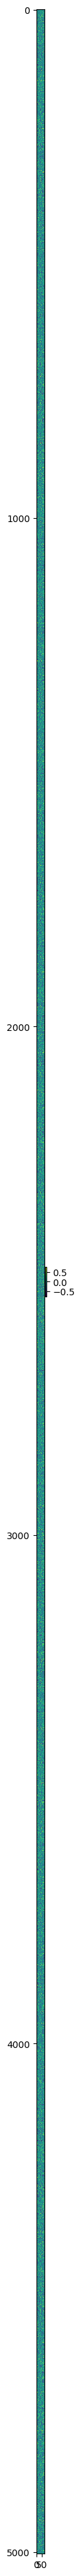

In [8]:
# Select first SNR
jj = 0
print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")

# SNR-specific parameters
inputScaling = inputScaler / (var_x[jj] ** 0.5) * np.ones(N_t * 2)
inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
TotalBerNum_ESN = 0
TotalBerNum_LS = 0
TotalBerNum_MMSE = 0
TotalBerNum_Perfect = 0
TotalBerDen = 0

# Process one pilot symbol (kk=1)
kk = 1
print(f"Processing pilot symbol {kk}")

# Channel Generation using Sionna CDL
batch_size = 1
num_time_samples = 1
a, tau = cdl(batch_size, num_time_samples, W)
a = a.numpy()
tau = tau.numpy()
h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
h_time = h_time.numpy()

# Compute R_h for MMSE
R_h = np.zeros((IsiDuration, IsiDuration))
for nnn in range(N_r):
    for mmm in range(N_t):
        tap_powers = np.abs(h_time[0, 0, nnn, 0, mmm, 0, :]) ** 2
        R_h += np.diag(tap_powers)
R_h /= (N_r * N_t)
MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N * (N / 2)) * np.eye(IsiDuration))

# Store channel for LS and MMSE estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]
        Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

# Pilot Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
        X[ii, iii] = ConstPilot[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Channel and Noise
y_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP[:, mmm], h_cdl, mode='full')
        y_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP[:, nnn] += noise
Y = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y[:, nnn] = 1 / N * np.fft.fft(y_CP[IsiDuration - 1:, nnn])

# Orthogonal Pilots for LS
X_LS = X.copy()
X_LS[np.arange(1, len(X_LS), 2), 0] = 0
X_LS[np.arange(0, len(X_LS), 2), 1] = 0
x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X_LS[:, iii])
    x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_LS_CP[:, mmm], h_cdl, mode='full')
        y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_LS_CP[:, nnn] += noise
Y_LS = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
Y_LS = Y_LS / (Pi[jj] ** 0.5)

# LS and MMSE Channel Estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
        c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
        c_MMSE = np.matmul(R_h, np.matmul(MMSE_bold_TD, c_LS))
        Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
        interp_x = np.append(np.arange(mmm, N, N_t), N - 1 if mmm == 0 else np.arange(mmm, N, N_t))
        interp_y = np.append(Ci_LS_Pilots[nnn][mmm], Ci_LS_Pilots[nnn][mmm][-1] if mmm == 0 else Ci_LS_Pilots[nnn][mmm])
        if mmm > 0:
            interp_x = np.append(0, interp_x)
            interp_y = np.append(Ci_LS_Pilots[nnn][mmm][0], interp_y)
        tmpf = interpolate.interp1d(interp_x, interp_y)
        Ci_LS[nnn][mmm] = tmpf(np.arange(N))

# ESN Training
esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
          sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
          teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)

# Simplified ESN training (no delay optimization)
ESN_input = np.zeros((N + Max_Delay + CyclicPrefixLen, N_t * 2))
ESN_output = np.zeros((N + Max_Delay + CyclicPrefixLen, N_t * 2))
ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Max_Delay))
ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Max_Delay))
ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Max_Delay))
ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Max_Delay))
ESN_output[:N + CyclicPrefixLen, 0] = x_CP[:, 0].real
ESN_output[:N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
ESN_output[:N + CyclicPrefixLen, 2] = x_CP[:, 1].real
ESN_output[:N + CyclicPrefixLen, 3] = x_CP[:, 1].imag

# Diagnostics
print(f"\n=== ESN Training Diagnostics ===")
print(f"ESN Input Norm: {np.linalg.norm(ESN_input)}")
print(f"ESN Output Norm: {np.linalg.norm(ESN_output)}")

# Train and Predict
nForgetPoints = CyclicPrefixLen
esn.fit(ESN_input, ESN_output, nForgetPoints)
x_hat_ESN_temp = esn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
x_hat_ESN_0 = x_hat_ESN_temp[:N, 0] + 1j * x_hat_ESN_temp[:N, 1]
x_hat_ESN_1 = x_hat_ESN_temp[:N, 2] + 1j * x_hat_ESN_temp[:N, 3]
x_hat_ESN = np.hstack((x_hat_ESN_0.reshape(-1, 1), x_hat_ESN_1.reshape(-1, 1)))
x = x_CP[IsiDuration - 1:, :]
NMSE_ESN = (
    np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
    np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
)

# Diagnostics
print(f"ESN Prediction Norm: {np.linalg.norm(x_hat_ESN)}")
print(f"True Signal Norm: {np.linalg.norm(x)}")
print(f"ESN NMSE Training: {NMSE_ESN}")

# Store results
ESN_train_input[kk - 1][jj] = ESN_input
ESN_train_teacher[kk - 1][jj] = ESN_output
NMSE_ESN_Training[jj] += NMSE_ESN
trainedEsn = esn
Delay = [0, 0, 0, 0]
Delay_Idx = 0
Delay_Min = 0
Delay_Max = Max_Delay

# Data Flow Check
print("\n=== Pilot Symbol Data Flow ===")
print(f"Channel c[0][0] shape: {c[0][0].shape}, first few taps: {c[0][0][:3]}")
print(f"Frequency response Ci[0][0] shape: {Ci[0][0].shape}, first few values: {Ci[0][0][:3]}")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y shape: {Y.shape}, first few symbols: {Y[:3, :]}")
print(f"LS Estimated Ci_LS[0][0] shape: {Ci_LS[0][0].shape}, first few values: {Ci_LS[0][0][:3]}")
print(f"MMSE Estimated Ci_MMSE[0][0] shape: {Ci_MMSE[0][0].shape}, first few values: {Ci_MMSE[0][0][:3]}")
print(f"ESN Input shape: {ESN_input.shape}, first few values: {ESN_input[:3, :]}")
print(f"ESN Output shape: {ESN_output.shape}, first few values: {ESN_output[:3, :]}")
print(f"Optimal Delays: {Delay}, Delay Index: {Delay_Idx}")

In [11]:
# Process one data symbol (kk=10)
kk = 10
print(f"\n=== Processing data symbol {kk} ===")

# SNR Diagnostic
effective_snr_db = 10 * np.log10(Ptotal[jj] / (No * W))
print(f"Effective SNR: {effective_snr_db:.2f} dB")

# Data Transmission with LDPC Encoding
info_bits = (np.random.uniform(0, 1, size=(num_codewords * k_ldpc, N_t)) > 0.5).astype(np.float32)
TxBits = np.zeros((N * m, N_t), dtype=np.int32)
for iii in range(N_t):
    info_bits_tx = info_bits[:, iii].reshape(num_codewords, k_ldpc)
    coded_bits = ldpc_encoder(info_bits_tx).numpy()
    TxBits[:, iii] = coded_bits.flatten().astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
        X[ii, iii] = Const[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Reception
y_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP[:, mmm], h_cdl, mode='full')
        y_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP[:, nnn] += noise
Y = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y[:, nnn] = 1 / N * np.fft.fft(y_CP[IsiDuration - 1:, nnn])

# ESN Detection
ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max))
ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max))
ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max))
ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max))
nForgetPoints = CyclicPrefixLen
x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
x_hat_ESN_0 = x_hat_ESN_temp[:N, 0] + 1j * x_hat_ESN_temp[:N, 1]
x_hat_ESN_1 = x_hat_ESN_temp[:N, 2] + 1j * x_hat_ESN_temp[:N, 3]
x_hat_ESN = np.hstack((x_hat_ESN_0.reshape(-1, 1), x_hat_ESN_1.reshape(-1, 1)))
x = x_CP[IsiDuration - 1:, :]
this_nmse = (
    np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
    np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
)
NMSE_ESN_Testing[jj] += this_nmse
X_hat_ESN = np.zeros(X.shape).astype('complex128')
for ii in range(N_t):
    X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
ESN_test_input[kk - 1][jj] = ESN_input
ESN_test_output[kk - 1][jj] = x_hat_ESN

# Classical Detection
H_temp = np.zeros((N_r, N_t)).astype('complex128')
H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
X_hat_Perfect = np.zeros(X.shape).astype('complex128')
X_hat_LS = np.zeros(X.shape).astype('complex128')
X_hat_MMSE = np.zeros(X.shape).astype('complex128')
for ii in range(N):
    Y_temp = np.transpose(Y[ii, :])
    for nnn in range(N_r):
        for mmm in range(N_t):
            H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
            H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
            H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
    X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
    X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
    X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

# LLR-based LDPC Decoding (Corrected)
def compute_llrs(x_hat, const, sigma2):
    llrs = np.zeros((N * m, N_t))
    const_power = np.mean(np.abs(const) ** 2)  # Normalize constellation power
    for ii in range(N):
        for iii in range(N_t):
            symbol = x_hat[ii, iii] / np.sqrt(const_power)  # Normalize received symbol
            llr_bits = np.zeros(m)
            for b in range(m):
                idx_0 = np.where(np.array([int(format(i, 'b').zfill(m)[b]) for i in range(len(const))]) == 0)[0]
                idx_1 = np.where(np.array([int(format(i, 'b').zfill(m)[b]) for i in range(len(const))]) == 1)[0]
                dist_0 = np.sum(np.abs(symbol - const[idx_0] / np.sqrt(const_power)) ** 2)
                dist_1 = np.sum(np.abs(symbol - const[idx_1] / np.sqrt(const_power)) ** 2)
                llr_bits[b] = (dist_0 - dist_1) / (2 * sigma2)
            llrs[m * ii:m * (ii + 1), iii] = llr_bits
    return llrs

sigma2 = No / 2
llrs_ESN = compute_llrs(X_hat_ESN, Const, sigma2)
llrs_LS = compute_llrs(X_hat_LS, Const, sigma2)
llrs_MMSE = compute_llrs(X_hat_MMSE, Const, sigma2)
llrs_Perfect = compute_llrs(X_hat_Perfect, Const, sigma2)

decoded_bits_ESN = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
decoded_bits_LS = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
decoded_bits_MMSE = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
decoded_bits_Perfect = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
for iii in range(N_t):
    llrs_ESN_tx = llrs_ESN[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
    llrs_LS_tx = llrs_LS[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
    llrs_MMSE_tx = llrs_MMSE[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
    llrs_Perfect_tx = llrs_Perfect[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
    decoded_bits_ESN[:, iii] = ldpc_decoder(llrs_ESN_tx).numpy().flatten().astype(np.int32)
    decoded_bits_LS[:, iii] = ldpc_decoder(llrs_LS_tx).numpy().flatten().astype(np.int32)
    decoded_bits_MMSE[:, iii] = ldpc_decoder(llrs_MMSE_tx).numpy().flatten().astype(np.int32)
    decoded_bits_Perfect[:, iii] = ldpc_decoder(llrs_Perfect_tx).numpy().flatten().astype(np.int32)

# Accumulate BER
bit_errors_ESN = np.sum(decoded_bits_ESN != info_bits.astype(np.int32))
bit_errors_LS = np.sum(decoded_bits_LS != info_bits.astype(np.int32))
bit_errors_MMSE = np.sum(decoded_bits_MMSE != info_bits.astype(np.int32))
bit_errors_Perfect = np.sum(decoded_bits_Perfect != info_bits.astype(np.int32))
TotalBerNum_ESN += bit_errors_ESN
TotalBerNum_LS += bit_errors_LS
TotalBerNum_MMSE += bit_errors_MMSE
TotalBerNum_Perfect += bit_errors_Perfect
TotalBerDen += num_codewords * k_ldpc * N_t

# Data Flow Check
print("\n=== Data Symbol Data Flow ===")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y shape: {Y.shape}, first few symbols: {Y[:3, :]}")
print(f"ESN Estimated X_hat_ESN shape: {X_hat_ESN.shape}, first few symbols: {X_hat_ESN[:3, :]}")
print(f"Perfect Estimated X_hat_Perfect shape: {X_hat_Perfect.shape}, first few symbols: {X_hat_Perfect[:3, :]}")
print(f"LS Estimated X_hat_LS shape: {X_hat_LS.shape}, first few symbols: {X_hat_LS[:3, :]}")
print(f"MMSE Estimated X_hat_MMSE shape: {X_hat_MMSE.shape}, first few symbols: {X_hat_MMSE[:3, :]}")
print(f"ESN NMSE Testing: {NMSE_ESN_Testing[jj]}")
print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
print(f"Total Bits: {TotalBerDen}")

# Initialize NMSE count
NMSE_count = 1

# Loop over additional data symbols (kk=3 to 6)
for kk in range(3, 7):
    print(f"\n=== Processing data symbol {kk} ===")

    # Data Transmission with LDPC Encoding
    info_bits = (np.random.uniform(0, 1, size=(num_codewords * k_ldpc, N_t)) > 0.5).astype(np.float32)
    TxBits = np.zeros((N * m, N_t), dtype=np.int32)
    for iii in range(N_t):
        info_bits_tx = info_bits[:, iii].reshape(num_codewords, k_ldpc)
        coded_bits = ldpc_encoder(info_bits_tx).numpy()
        TxBits[:, iii] = coded_bits.flatten().astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
            X[ii, iii] = Const[ThisQamIdx[0]]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Reception
    y_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP[:, mmm], h_cdl, mode='full')
            y_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP[:, nnn] += noise
    Y = np.zeros((N, N_r)).astype('complex128')
    for nnn in range(N_r):
        Y[:, nnn] = 1 / N * np.fft.fft(y_CP[IsiDuration - 1:, nnn])

    # ESN Detection
    ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
    ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max))
    ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max))
    ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max))
    ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max))
    nForgetPoints = CyclicPrefixLen
    x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
    x_hat_ESN_0 = x_hat_ESN_temp[:N, 0] + 1j * x_hat_ESN_temp[:N, 1]
    x_hat_ESN_1 = x_hat_ESN_temp[:N, 2] + 1j * x_hat_ESN_temp[:N, 3]
    x_hat_ESN = np.hstack((x_hat_ESN_0.reshape(-1, 1), x_hat_ESN_1.reshape(-1, 1)))
    x = x_CP[IsiDuration - 1:, :]
    this_nmse = (
        np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
        np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
    )
    NMSE_ESN_Testing[jj] += this_nmse
    NMSE_count += 1
    X_hat_ESN = np.zeros(X.shape).astype('complex128')
    for ii in range(N_t):
        X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
    ESN_test_input[kk - 1][jj] = ESN_input
    ESN_test_output[kk - 1][jj] = x_hat_ESN

    # Classical Detection
    H_temp = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
    X_hat_Perfect = np.zeros(X.shape).astype('complex128')
    X_hat_LS = np.zeros(X.shape).astype('complex128')
    X_hat_MMSE = np.zeros(X.shape).astype('complex128')
    for ii in range(N):
        Y_temp = np.transpose(Y[ii, :])
        for nnn in range(N_r):
            for mmm in range(N_t):
                H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
        X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
        X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
        X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

    # LLR-based LDPC Decoding (Corrected)
    llrs_ESN = compute_llrs(X_hat_ESN, Const, sigma2)
    llrs_LS = compute_llrs(X_hat_LS, Const, sigma2)
    llrs_MMSE = compute_llrs(X_hat_MMSE, Const, sigma2)
    llrs_Perfect = compute_llrs(X_hat_Perfect, Const, sigma2)

    decoded_bits_ESN = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
    decoded_bits_LS = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
    decoded_bits_MMSE = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
    decoded_bits_Perfect = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
    for iii in range(N_t):
        llrs_ESN_tx = llrs_ESN[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
        llrs_LS_tx = llrs_LS[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
        llrs_MMSE_tx = llrs_MMSE[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
        llrs_Perfect_tx = llrs_Perfect[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
        decoded_bits_ESN[:, iii] = ldpc_decoder(llrs_ESN_tx).numpy().flatten().astype(np.int32)
        decoded_bits_LS[:, iii] = ldpc_decoder(llrs_LS_tx).numpy().flatten().astype(np.int32)
        decoded_bits_MMSE[:, iii] = ldpc_decoder(llrs_MMSE_tx).numpy().flatten().astype(np.int32)
        decoded_bits_Perfect[:, iii] = ldpc_decoder(llrs_Perfect_tx).numpy().flatten().astype(np.int32)

    # Accumulate BER
    bit_errors_ESN = np.sum(decoded_bits_ESN != info_bits.astype(np.int32))
    bit_errors_LS = np.sum(decoded_bits_LS != info_bits.astype(np.int32))
    bit_errors_MMSE = np.sum(decoded_bits_MMSE != info_bits.astype(np.int32))
    bit_errors_Perfect = np.sum(decoded_bits_Perfect != info_bits.astype(np.int32))
    TotalBerNum_ESN += bit_errors_ESN
    TotalBerNum_LS += bit_errors_LS
    TotalBerNum_MMSE += bit_errors_MMSE
    TotalBerNum_Perfect += bit_errors_Perfect
    TotalBerDen += num_codewords * k_ldpc * N_t

    # Per-symbol print
    print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
    print(f"ESN NMSE (this symbol): {this_nmse}")

# Compute averages (1 pilot, 5 data symbols: kk=2,3,4,5,6)
num_symbols_so_far = 6
num_pilots = 1
BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
BER_LS[jj] = TotalBerNum_LS / TotalBerDen
BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
NMSE_ESN_Training[jj] /= num_pilots
NMSE_ESN_Testing[jj] /= NMSE_count

# Data Flow Check: Final for this SNR segment
print(f"\n=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===")
print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
print(f"Total Bits Processed: {TotalBerDen}")


=== Processing data symbol 10 ===
Effective SNR: -23.06 dB

=== Data Symbol Data Flow ===
Transmitted X shape: (64, 2), first few symbols: [[ 0.9486833 -0.31622777j -0.9486833 -0.31622777j]
 [ 0.9486833 +0.31622777j  0.9486833 -0.9486833j ]
 [ 0.31622777+0.9486833j   0.31622777-0.9486833j ]]
Received Y shape: (64, 2), first few symbols: [[-0.06443657-0.07449039j -0.04311178-0.03732882j]
 [ 0.0246439 -0.07494755j  0.01566463-0.00487682j]
 [ 0.06780535-0.06768877j  0.03472448-0.04551851j]]
ESN Estimated X_hat_ESN shape: (64, 2), first few symbols: [[ 0.73645317-1.06802198j -1.19904701-0.92656072j]
 [ 0.65839825-0.75052526j  0.58163542-1.56229308j]
 [ 0.25435603-0.13370895j  0.02189675-1.593867j  ]]
Perfect Estimated X_hat_Perfect shape: (64, 2), first few symbols: [[ 0.94635958-0.32603039j -0.94983906-0.31529875j]
 [ 0.95586665+0.31846493j  0.94550859-0.94801703j]
 [ 0.3268558 +0.94508748j  0.33294797-0.94297175j]]
LS Estimated X_hat_LS shape: (64, 2), first few symbols: [[ 0.94204874-0

In [18]:
import numpy as np
import math
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf

from sionna.channel.tr38901 import CDL, PanelArray
from sionna.channel import cir_to_time_channel
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

# Helper Functions (HelpFunc and ESN from base, with fixes)
class HelpFunc:
    @staticmethod
    def UnitQamConstellation(Bi):
        EvenSquareRoot = math.ceil(math.sqrt(2 ** Bi) / 2) * 2
        PamM = EvenSquareRoot
        PamConstellation = np.arange(-(PamM - 1), PamM, 2).astype(np.int32)
        PamConstellation = np.reshape(PamConstellation, (1, -1))
        SquareMatrix = np.matmul(np.ones((PamM, 1)), PamConstellation)
        C = SquareMatrix + 1j * (SquareMatrix.T)
        C_tmp = np.zeros(C.shape[0] * C.shape[1]).astype('complex128')
        for i in range(C.shape[1]):
            for j in range(C.shape[0]):
                C_tmp[i * C.shape[0] + j] = C[j][i]
        C = C_tmp
        return C / math.sqrt(np.mean(abs(C) ** 2))

    @staticmethod
    def trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP, x_CP):
        if DelayFlag:
            Delay_LUT = np.zeros(((Max_Delay + 1 - Min_Delay) ** 4, 4)).astype('int32')
            count = 0
            temp = np.zeros(Delay_LUT.shape[0])
            for ii in range(Min_Delay, Max_Delay + 1):
                for jj in range(Min_Delay, Max_Delay + 1):
                    for kk in range(Min_Delay, Max_Delay + 1):
                        for ll in range(Min_Delay, Max_Delay + 1):
                            Delay_LUT[count, :] = np.array([ii, jj, kk, ll])
                            if (abs(ii - jj) > 2 or abs(kk - ll) > 2 or abs(ii - kk) > 2 or
                                abs(ii - ll) > 2 or abs(jj - kk) > 2 or abs(jj - ll) > 2):
                                temp[count] = 1
                            count += 1
            Delay_LUT = np.delete(Delay_LUT, np.where(temp > 0)[0], axis=0)
        else:
            Delay_LUT = np.zeros((Max_Delay - Min_Delay + 1, 4)).astype('int32')
            for jjjj in range(Min_Delay, Max_Delay + 1):
                Delay_LUT[jjjj - Min_Delay, :] = jjjj * np.ones(4)

        Delay_Max = np.amax(Delay_LUT, axis=1)
        Delay_Min = np.amin(Delay_LUT, axis=1)
        NMSE_ESN_Training = np.zeros(Delay_LUT.shape[0])
        for jjj in range(Delay_LUT.shape[0]):
            Curr_Delay = Delay_LUT[jjj, :]
            ESN_input = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_output = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[jjj]))
            ESN_output[Curr_Delay[0]: Curr_Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
            ESN_output[Curr_Delay[1]: Curr_Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
            ESN_output[Curr_Delay[2]: Curr_Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
            ESN_output[Curr_Delay[3]: Curr_Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
            nForgetPoints = Delay_Min[jjj] + CyclicPrefixLen
            esn.fit(ESN_input, ESN_output, nForgetPoints)
            x_hat_ESN_temp = esn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
            x_hat_ESN_0 = x_hat_ESN_temp[Curr_Delay[0] - Delay_Min[jjj]: Curr_Delay[0] - Delay_Min[jjj] + N + 1, 0] + 1j * x_hat_ESN_temp[Curr_Delay[1] - Delay_Min[jjj]: Curr_Delay[1] - Delay_Min[jjj] + N + 1, 1]
            x_hat_ESN_1 = x_hat_ESN_temp[Curr_Delay[2] - Delay_Min[jjj]: Curr_Delay[2] - Delay_Min[jjj] + N + 1, 2] + 1j * x_hat_ESN_temp[Curr_Delay[3] - Delay_Min[jjj]: Curr_Delay[3] - Delay_Min[jjj] + N + 1, 3]
            x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
            x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
            x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
            x = x_CP[IsiDuration - 1:, :]
            NMSE_ESN_Training[jjj] = (
                np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
                np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
            )
        Delay_Idx = np.argmin(NMSE_ESN_Training)
        NMSE_ESN = np.min(NMSE_ESN_Training)
        Delay = Delay_LUT[Delay_Idx, :]
        ESN_input = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_output = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_output[Delay[0]: Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
        ESN_output[Delay[1]: Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
        ESN_output[Delay[2]: Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
        ESN_output[Delay[3]: Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
        nForgetPoints = Delay_Min[Delay_Idx] + CyclicPrefixLen
        esn.fit(ESN_input, ESN_output, nForgetPoints)
        Delay_Minn = Delay_Min[Delay_Idx]
        Delay_Maxx = Delay_Max[Delay_Idx]
        return [ESN_input, ESN_output, esn, Delay, Delay_Idx, Delay_Minn, Delay_Maxx, nForgetPoints, NMSE_ESN]

def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s

def identity(x):
    return x

class ESN:
    def __init__(self, n_inputs, n_outputs, n_reservoir=200, spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None, teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity, random_state=None, silent=True):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            self.random_state_ = np.random.RandomState(random_state)
        else:
            self.random_state_ = np.random.mtrand._rand
        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1
        self.W_feedb = self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern) + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        return np.tanh(preactivation) + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5)

    def _scale_inputs(self, inputs):
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, nForgetPoints=0, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], teachers_scaled[n - 1, :])
        transient = max(0, nForgetPoints)
        extended_states = np.hstack((states, inputs_scaled))
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]), self.inverse_out_activation(teachers_scaled[transient:, :])).T
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
        pred_train = self._unscale_teacher(self.out_activation(np.dot(extended_states, self.W_out.T)))
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)
        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack([laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack([lastoutput, np.zeros((n_samples, self.n_outputs))])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out, np.concatenate([states[n + 1, :], inputs[n + 1, :]])))
        return self._unscale_teacher(self.out_activation(outputs[1:]))

# Sionna Setup
carrier_frequency = 3.5e9
delay_spread = 300e-9
N_r, N_t = 2, 2
bs_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=1, polarization='dual', polarization_type='VH', antenna_pattern='38.901', carrier_frequency=carrier_frequency)
ut_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=1, polarization='dual', polarization_type='VH', antenna_pattern='omni', carrier_frequency=carrier_frequency)
cdl = CDL(model="C", delay_spread=delay_spread, carrier_frequency=carrier_frequency, ut_array=ut_array, bs_array=bs_array, direction="downlink", min_speed=0., max_speed=0., dtype=tf.complex64)

# LDPC Setup
code_rate = 1/2
n_ldpc = 64 * 4  # N * m
k_ldpc = int(n_ldpc * code_rate)
num_codewords = 1
ldpc_encoder = LDPC5GEncoder(k=k_ldpc, n=n_ldpc, dtype=tf.float32)
ldpc_decoder = LDPC5GDecoder(encoder=ldpc_encoder, num_iter=20)

# Physical parameters
W = 2*1.024e6
f_D = 100
No = 0.00001
IsiDuration = 8
cFlag = False
EbNoDB = np.arange(25, 30+1, 5).astype(np.int32)

# MIMO Parameters
N = 64
Subcarrier_Spacing = W / N
m = 4
m_pilot = 4
NumOfdmSymbols = 100  # Reduced for testing; set to 1000 for full
Ptotal = 10**(EbNoDB/10)*No*N * code_rate

# Power Amplifier
#p_smooth = 1
#ClipLeveldB = 3

# Secondary Parameters
T_OFDM = N/W
T_OFDM_Total = (N + IsiDuration -1)/W
T_s = 1/W
tau_c = 0.5/f_D
L = math.floor(tau_c/T_OFDM_Total)
Pi = Ptotal/N
NumBitsPerSymbol = m*N
Const = HelpFunc.UnitQamConstellation(m)
ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)
PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
CyclicPrefixLen = IsiDuration - 1

# ESN Parameters
var_x = np.float_power(10, (EbNoDB/10))*No*N * code_rate
nInputUnits = N_t*2
nOutputUnits = N_t*2
nInternalUnits = 64
inputScaler = 0.005
inputOffset = 0.0
feedbackScaler = 0.0
teacherScaling = 0.0000005*np.ones(N_t*2)
spectralRadius = 0.9
teacherShift = np.zeros(N_t*2)
feedbackScaling = feedbackScaler*np.ones(N_t*2)
Min_Delay = 0
Max_Delay = math.ceil(IsiDuration/2) + 2
DelayFlag = 0

# Initializations
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = [[None] * N_t for _ in range(N_r)]
Ci = [[None] * N_t for _ in range(N_r)]
Ci_LS = [[None] * N_t for _ in range(N_r)]
Ci_MMSE = [[None] * N_t for _ in range(N_r)]
Ci_LS_Pilots = [[None] * N_t for _ in range(N_r)]
MMSEScaler = (No/Pi)
R_h = np.zeros((IsiDuration, IsiDuration))
for ii in range(IsiDuration):
    R_h[ii, ii] = 1.0 / IsiDuration  # Uniform for simplicity

# Simulation
for jj in range(len(EbNoDB)):
    print(f'EbNoDB = {EbNoDB[jj]}')
    A_Clip = np.sqrt(var_x[jj])* np.float_power(10, ClipLeveldB/20)
    inputScaling = inputScaler/(var_x[jj]**0.5)*np.ones(N_t*2)
    inputShift = inputOffset/inputScaler*np.ones(N_t * 2)
    TotalBerNum_ESN = 0
    TotalBerNum_LS = 0
    TotalBerNum_MMSE = 0
    TotalBerNum_Perfect = 0
    TotalBerDen = 0
    NMSE_count = 0
    MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj]/(N/2) * np.eye(IsiDuration))
    trainedEsn = None
    Delay = None
    Delay_Min = None
    Delay_Max = None

    for kk in range(1, NumOfdmSymbols+1):
        # Generate channel using Sionna
        batch_size = 1
        num_time_samples = 1
        a, tau = cdl(batch_size, num_time_samples, W)
        a = a.numpy()
        tau = tau.numpy()
        h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
        h_time = h_time.numpy()

        for nnn in range(N_r):
            for mmm in range(N_t):
                c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]
                Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

        if (kk % L == 1):
            # Pilot symbol
            TxBits = (np.random.uniform(0, 1, size=(N*m_pilot,N_t)) > 0.5).astype(np.int32)
            X = np.zeros((N, N_t)).astype('complex128')
            x_CP = np.zeros((N+CyclicPrefixLen, N_t)).astype('complex128')
            for ii in range(N):
                for iii in range(N_t):
                    ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
                    X[ii, iii] = ConstPilot[ThisQamIdx[0]]
            for iii in range(N_t):
                x_temp = N * np.fft.ifft(X[:, iii])
                x_CP[:, iii] = np.append(x_temp[-CyclicPrefixLen:], x_temp)
                x_CP[:, iii] = x_CP[:, iii] * (Pi[jj]**0.5)

            x_CP_NLD = x_CP / ((1 + (np.abs(x_CP)/A_Clip)**(2*p_smooth))**(1/(2*p_smooth)))

            y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
            for nnn in range(N_r):
                for mmm in range(N_t):
                    conv_result = np.convolve(x_CP_NLD[:, mmm], c[nnn][mmm], mode='full')
                    y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
                noise = np.sqrt((N + CyclicPrefixLen)*No/2) * (np.random.randn(N + CyclicPrefixLen) + 1j * np.random.randn(N + CyclicPrefixLen))
                y_CP_NLD[:, nnn] += noise

            # LS and MMSE estimation
            X_LS = X.copy()
            X_LS[1::2, 0] = 0
            X_LS[0::2, 1] = 0
            x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
            for iii in range(N_t):
                x_temp = N * np.fft.ifft(X_LS[:, iii])
                x_LS_CP[:, iii] = np.append(x_temp[-CyclicPrefixLen:], x_temp)
                x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj]**0.5)
            y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
            for nnn in range(N_r):
                for mmm in range(N_t):
                    conv_result = np.convolve(x_LS_CP[:, mmm], c[nnn][mmm], mode='full')
                    y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
                y_LS_CP[:, nnn] += noise
            Y_LS = np.zeros((N, N_r)).astype('complex128')
            for nnn in range(N_r):
                Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration-1:, nnn])
            Y_LS = Y_LS / (Pi[jj]**0.5)

            for nnn in range(N_r):
                for mmm in range(N_t):
                    Ci_LS_Pilots[nnn][mmm] = Y_LS[mmm::2, nnn] / X_LS[mmm::2, mmm]
                    c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
                    c_MMSE = np.matmul(MMSE_bold_TD, c_LS)
                    Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
                    interp_x = np.arange(mmm, N, N_t)
                    interp_y = Ci_LS_Pilots[nnn][mmm]
                    if mmm == 0:
                        interp_x = np.append(interp_x, N-1)
                        interp_y = np.append(interp_y, interp_y[-1])
                    else:
                        interp_x = np.append(0, interp_x)
                        interp_y = np.append(interp_y[0], interp_y)
                    tmpf = interpolate.interp1d(interp_x, interp_y)
                    Ci_LS[nnn][mmm] = tmpf(np.arange(N))

            # ESN Training
            esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius, sparsity=1 - min(0.2*nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling, teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
            [ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = HelpFunc.trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
            NMSE_ESN_Training[jj] += NMSE_ESN

        else:
            # Data symbol with LDPC
            info_bits = (np.random.rand(num_codewords * k_ldpc * N_t) > 0.5).astype(np.float32)
            TxBits = np.zeros((N*m, N_t), dtype=np.int32)
            for iii in range(N_t):
                info_bits_tx = info_bits[iii*num_codewords*k_ldpc:(iii+1)*num_codewords*k_ldpc].reshape(num_codewords, k_ldpc)
                coded_bits = ldpc_encoder(info_bits_tx).numpy()
                TxBits[:, iii] = coded_bits.flatten().astype(np.int32)
            X = np.zeros((N, N_t)).astype('complex128')
            x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
            for ii in range(N):
                for iii in range(N_t):
                    ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
                    X[ii, iii] = Const[ThisQamIdx[0]]
            for iii in range(N_t):
                x_temp = N * np.fft.ifft(X[:, iii])
                x_CP[:, iii] = np.append(x_temp[-CyclicPrefixLen:], x_temp)
                x_CP[:, iii] = x_CP[:, iii] * (Pi[jj]**0.5)

            x_CP_NLD = x_CP / ((1 + (np.abs(x_CP)/A_Clip)**(2*p_smooth))**(1/(2*p_smooth)))

            y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
            for nnn in range(N_r):
                for mmm in range(N_t):
                    conv_result = np.convolve(x_CP_NLD[:, mmm], c[nnn][mmm], mode='full')
                    y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
                noise = np.sqrt((N + CyclicPrefixLen)*No/2) * (np.random.randn(N + CyclicPrefixLen) + 1j * np.random.randn(N + CyclicPrefixLen))
                y_CP_NLD[:, nnn] += noise
            Y_NLD = np.zeros((N, N_r)).astype('complex128')
            for nnn in range(N_r):
                Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration-1:, nnn])

            # ESN Detection
            ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
            ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
            ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
            ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
            ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
            nForgetPoints = Delay_Min + CyclicPrefixLen
            x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
            x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
            x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
            x_hat_ESN = np.hstack((x_hat_ESN_0.reshape(-1, 1), x_hat_ESN_1.reshape(-1, 1)))
            x = x_CP[IsiDuration - 1:, :]
            this_nmse = np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 + np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
            NMSE_ESN_Testing[jj] += this_nmse
            NMSE_count += 1
            X_hat_ESN = np.zeros(X.shape).astype('complex128')
            for ii in range(N_t):
                X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])

            # Classical Detection
            H_temp = np.zeros((N_r, N_t)).astype('complex128')
            H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
            H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
            X_hat_Perfect = np.zeros(X.shape).astype('complex128')
            X_hat_LS = np.zeros(X.shape).astype('complex128')
            X_hat_MMSE = np.zeros(X.shape).astype('complex128')
            for ii in range(N):
                Y_temp = Y_NLD[ii, :].T
                for nnn in range(N_r):
                    for mmm in range(N_t):
                        H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                        H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                        H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
                X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
                X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
                X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

            # LLR Computation for LDPC
            sigma2 = No / 2
            def compute_llrs(x_hat, const, sigma2):
                llrs = np.zeros((N * m, N_t))
                const_power = np.mean(np.abs(const) ** 2)
                for ii in range(N):
                    for iii in range(N_t):
                        symbol = x_hat[ii, iii] / np.sqrt(const_power)
                        llr_bits = np.zeros(m)
                        for b in range(m):
                            idx_0 = np.bitwise_and(np.arange(len(const)), 1 << b) == 0
                            idx_1 = np.bitwise_and(np.arange(len(const)), 1 << b) != 0
                            dist_0 = np.sum(np.abs(symbol - const[idx_0] / np.sqrt(const_power)) ** 2)
                            dist_1 = np.sum(np.abs(symbol - const[idx_1] / np.sqrt(const_power)) ** 2)
                            llr_bits[b] = (dist_1 - dist_0) / (2 * sigma2)  # Positive for bit=1 likely
                        llrs[m * ii:m * (ii + 1), iii] = llr_bits
                return llrs

            llrs_ESN = compute_llrs(X_hat_ESN, Const, sigma2)
            llrs_LS = compute_llrs(X_hat_LS, Const, sigma2)
            llrs_MMSE = compute_llrs(X_hat_MMSE, Const, sigma2)
            llrs_Perfect = compute_llrs(X_hat_Perfect, Const, sigma2)

            decoded_bits_ESN = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
            decoded_bits_LS = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
            decoded_bits_MMSE = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
            decoded_bits_Perfect = np.zeros((num_codewords * k_ldpc, N_t), dtype=np.int32)
            for iii in range(N_t):
                llrs_ESN_tx = llrs_ESN[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
                llrs_LS_tx = llrs_LS[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
                llrs_MMSE_tx = llrs_MMSE[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
                llrs_Perfect_tx = llrs_Perfect[:, iii].reshape(num_codewords, n_ldpc).astype(np.float32)
                decoded_bits_ESN[:, iii] = ldpc_decoder(llrs_ESN_tx).numpy().flatten().astype(np.int32)
                decoded_bits_LS[:, iii] = ldpc_decoder(llrs_LS_tx).numpy().flatten().astype(np.int32)
                decoded_bits_MMSE[:, iii] = ldpc_decoder(llrs_MMSE_tx).numpy().flatten().astype(np.int32)
                decoded_bits_Perfect[:, iii] = ldpc_decoder(llrs_Perfect_tx).numpy().flatten().astype(np.int32)

            bit_errors_ESN = np.sum(decoded_bits_ESN != info_bits.reshape(num_codewords * k_ldpc, N_t).astype(np.int32))
            bit_errors_LS = np.sum(decoded_bits_LS != info_bits.reshape(num_codewords * k_ldpc, N_t).astype(np.int32))
            bit_errors_MMSE = np.sum(decoded_bits_MMSE != info_bits.reshape(num_codewords * k_ldpc, N_t).astype(np.int32))
            bit_errors_Perfect = np.sum(decoded_bits_Perfect != info_bits.reshape(num_codewords * k_ldpc, N_t).astype(np.int32))
            TotalBerNum_ESN += bit_errors_ESN
            TotalBerNum_LS += bit_errors_LS
            TotalBerNum_MMSE += bit_errors_MMSE
            TotalBerNum_Perfect += bit_errors_Perfect
            TotalBerDen += num_codewords * k_ldpc * N_t

    BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
    BER_LS[jj] = TotalBerNum_LS / TotalBerDen
    BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
    BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
    NMSE_ESN_Testing[jj] /= NMSE_count if NMSE_count > 0 else 1
    NMSE_ESN_Training[jj] /= (NumOfdmSymbols / L)

# Save and Plot
BERvsEBNo = {"EBN0": EbNoDB, "BER_ESN": BER_ESN, "BER_LS": BER_LS, "BER_MMSE": BER_MMSE, "BER_Perfect": BER_Perfect}
with open('./BERvsEBNo_esn.pkl', 'wb') as f:
    pickle.dump(BERvsEBNo, f)

with open('ber_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["EbNoDB (dB)", "BER_ESN", "BER_LS", "BER_MMSE", "BER_Perfect"])
    for i in range(len(EbNoDB)):
        writer.writerow([EbNoDB[i], BER_ESN[i], BER_LS[i], BER_MMSE[i], BER_Perfect[i]])

plt.semilogy(EbNoDB, BER_ESN, 'gd--', label='ESN', linewidth=1.5)
plt.semilogy(EbNoDB, BER_LS, 'o-', label='LS', linewidth=1.5)
plt.semilogy(EbNoDB, BER_MMSE, 'rs-.', label='MMSE', linewidth=1.5)
plt.semilogy(EbNoDB, BER_Perfect, 'k-', label='Perfect', linewidth=1.5)
plt.legend()
plt.grid(True)
plt.title('BER vs SNR - ESN vs Baselines (Coded)')
plt.xlabel('Eb/N0 [dB]')
plt.ylabel('Bit Error Rate (BER)')
plt.tight_layout()
plt.savefig("ber_vs_snr_esn.png", dpi=300)

# Constellation plot (as in base)
np.random.seed(0)
num_symbols = 200
constellation = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
tx_symbols = np.random.choice(constellation, num_symbols)
rx_symbols_esn = tx_symbols + 0.3*(np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols))
plt.figure(figsize=(6, 6))
plt.scatter(np.real(rx_symbols_esn), np.imag(rx_symbols_esn), s=20, c='blue', alpha=0.6, label='ESN Output')
plt.scatter(np.real(tx_symbols), np.imag(tx_symbols), s=20, c='green', alpha=0.3, label='Transmitted')
plt.scatter(np.real(constellation), np.imag(constellation), c='red', s=80, marker='x', label='Ideal Points')
plt.grid(True)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.title('Constellation Diagram (Predicted vs True)')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.savefig("constellation.png", dpi=300)

EbNoDB = 25


KeyboardInterrupt: 

EbNoDB = 25


KeyboardInterrupt: 

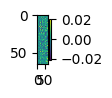

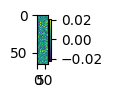

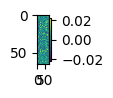

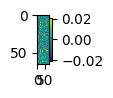

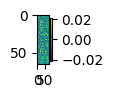

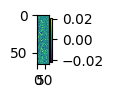

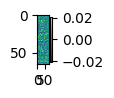

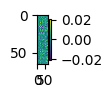

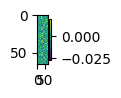

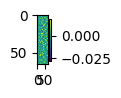

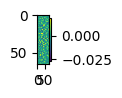

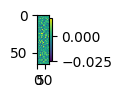

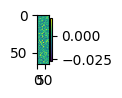

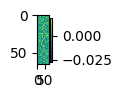

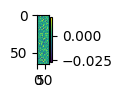

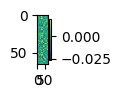

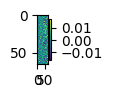

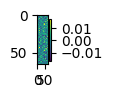

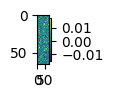

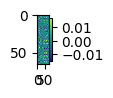

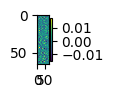

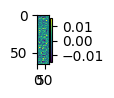

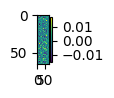

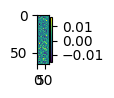

In [27]:
from HelpFunc import HelpFunc
from pyESN import ESN
import numpy as np
import math
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from sionna.channel.tr38901 import CDL, PanelArray
from sionna.channel import cir_to_time_channel
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

class HelpFunc:
    @staticmethod
    def UnitQamConstellation(Bi):
        EvenSquareRoot = math.ceil(math.sqrt(2 ** Bi) / 2) * 2
        PamM = EvenSquareRoot
        PamConstellation = np.arange(-(PamM - 1), PamM, 2).astype(np.int32)
        PamConstellation = np.reshape(PamConstellation, (1, -1))
        SquareMatrix = np.matmul(np.ones((PamM, 1)), PamConstellation)
        C = SquareMatrix + 1j * (SquareMatrix.T)
        C_tmp = np.zeros(C.shape[0] * C.shape[1]).astype('complex128')
        for i in range(C.shape[1]):
            for j in range(C.shape[0]):
                C_tmp[i * C.shape[0] + j] = C[j][i]
        C = C_tmp
        return C / math.sqrt(np.mean(abs(C) ** 2))

def trainSISOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, IsiDuration, y_CP, x_CP):
    if DelayFlag:
        Delay_LUT = np.zeros(((Max_Delay + 1 - Min_Delay) ** 2, 2)).astype('int32')
        count = 0
        temp = np.zeros(Delay_LUT.shape[0])
        for ii in range(Min_Delay, Max_Delay + 1):
            for jj in range(Min_Delay, Max_Delay + 1):
                Delay_LUT[count, :] = np.array([ii, jj])
                if abs(ii - jj) > 2:
                    temp[count] = 1
                count += 1
        Delay_LUT = np.delete(Delay_LUT, np.where(temp > 0)[0], axis=0)
    else:
        Delay_LUT = np.zeros((Max_Delay - Min_Delay + 1, 2)).astype('int32')
        for jjjj in range(Min_Delay, Max_Delay + 1):
            Delay_LUT[jjjj - Min_Delay, :] = jjjj * np.ones(2)

    Delay_Max = np.amax(Delay_LUT, axis=1)
    Delay_Min = np.amin(Delay_LUT, axis=1)
    NMSE_ESN_Training = np.zeros(Delay_LUT.shape[0])
    for jjj in range(Delay_LUT.shape[0]):
        Curr_Delay = Delay_LUT[jjj, :]
        ESN_input = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, 2))
        ESN_output = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, 2))
        ESN_input[:, 0] = np.append(y_CP.real, np.zeros(Delay_Max[jjj]))
        ESN_input[:, 1] = np.append(y_CP.imag, np.zeros(Delay_Max[jjj]))
        ESN_output[Curr_Delay[0]: Curr_Delay[0] + N + CyclicPrefixLen, 0] = x_CP.real
        ESN_output[Curr_Delay[1]: Curr_Delay[1] + N + CyclicPrefixLen, 1] = x_CP.imag
        nForgetPoints = Delay_Min[jjj] + CyclicPrefixLen
        esn.fit(ESN_input, ESN_output, nForgetPoints)
        x_hat_ESN_temp = esn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
        x_hat_ESN = x_hat_ESN_temp[Curr_Delay[0] - Delay_Min[jjj]: Curr_Delay[0] - Delay_Min[jjj] + N, 0] + 1j * x_hat_ESN_temp[Curr_Delay[1] - Delay_Min[jjj]: Curr_Delay[1] - Delay_Min[jjj] + N, 1]
        x = x_CP[IsiDuration - 1:]
        NMSE_ESN_Training[jjj] = np.linalg.norm(x_hat_ESN - x) ** 2 / np.linalg.norm(x) ** 2
    Delay_Idx = np.argmin(NMSE_ESN_Training)
    NMSE_ESN = np.min(NMSE_ESN_Training)
    Delay = Delay_LUT[Delay_Idx, :]
    ESN_input = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, 2))
    ESN_output = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, 2))
    ESN_input[:, 0] = np.append(y_CP.real, np.zeros(Delay_Max[Delay_Idx]))
    ESN_input[:, 1] = np.append(y_CP.imag, np.zeros(Delay_Max[Delay_Idx]))
    ESN_output[Delay[0]: Delay[0] + N + CyclicPrefixLen, 0] = x_CP.real
    ESN_output[Delay[1]: Delay[1] + N + CyclicPrefixLen, 1] = x_CP.imag
    nForgetPoints = Delay_Min[Delay_Idx] + CyclicPrefixLen
    esn.fit(ESN_input, ESN_output, nForgetPoints)
    Delay_Minn = Delay_Min[Delay_Idx]
    Delay_Maxx = Delay_Max[Delay_Idx]
    return [ESN_input, ESN_output, esn, Delay, Delay_Idx, Delay_Minn, Delay_Maxx, nForgetPoints, NMSE_ESN]

# Sionna Setup for SISO
carrier_frequency = 3.5e9
delay_spread = 300e-9
N_r, N_t = 1, 1
bs_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=1, polarization='single', polarization_type='V', antenna_pattern='38.901', carrier_frequency=carrier_frequency)
ut_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=1, polarization='single', polarization_type='V', antenna_pattern='omni', carrier_frequency=carrier_frequency)
cdl = CDL(model="C", delay_spread=delay_spread, carrier_frequency=carrier_frequency, ut_array=ut_array, bs_array=bs_array, direction="downlink", min_speed=0., max_speed=0., dtype=tf.complex64)

# LDPC Setup
code_rate = 1/2
n_ldpc = 64 * 4  # N * m
k_ldpc = int(n_ldpc * code_rate)
num_codewords = 1
ldpc_encoder = LDPC5GEncoder(k=k_ldpc, n=n_ldpc, dtype=tf.float32)
ldpc_decoder = LDPC5GDecoder(encoder=ldpc_encoder, num_iter=20)

# Physical parameters
W = 2*1.024e6
f_D = 100
No = 0.00001
IsiDuration = 8
EbNoDB = np.arange(25, 31, 5).astype(np.int32)  # Full range for complete graph

# Parameters
N = 64
Subcarrier_Spacing = W / N
m = 4
m_pilot = 4
NumOfdmSymbols = 500  # Balanced for time and statistics
Ptotal = 10**(EbNoDB/10)*No*N * code_rate

# Secondary Parameters
T_OFDM = N/W
T_OFDM_Total = (N + IsiDuration -1)/W
T_s = 1/W
tau_c = 0.5/f_D
L = math.floor(tau_c/T_OFDM_Total)
Pi = Ptotal/N
NumBitsPerSymbol = m*N
Const = HelpFunc.UnitQamConstellation(m)
ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)
PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
CyclicPrefixLen = IsiDuration - 1

# ESN Parameters
var_x = np.power(10, (EbNoDB/10))*No*N * code_rate
nInputUnits = 2
nOutputUnits = 2
nInternalUnits = 64
inputScaler = 0.005
inputOffset = 0.0
feedbackScaler = 0.0
teacherScaling = 0.0000005*np.ones(2)
spectralRadius = 0.9
teacherShift = np.zeros(2)
feedbackScaling = feedbackScaler*np.ones(2)
Min_Delay = 0
Max_Delay = math.ceil(IsiDuration/2) + 2
DelayFlag = 0

# Initializations
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = np.zeros(IsiDuration).astype('complex128')
Ci = np.zeros(N).astype('complex128')
Ci_LS = np.zeros(N).astype('complex128')
Ci_MMSE = np.zeros(N).astype('complex128')
MMSEScaler = (No/Pi)
R_h = np.eye(IsiDuration) / IsiDuration  # Uniform PDP for simplicity

# Lists for constellation (collect from last data symbol per SNR)
const_tx = []
const_esn = []
const_mmse = []

# Simulation
for jj in range(len(EbNoDB)):
    print(f'EbNoDB = {EbNoDB[jj]}')
    inputScaling = inputScaler/(var_x[jj]**0.5)*np.ones(2)
    inputShift = inputOffset/inputScaler*np.ones(2)
    TotalBerNum_ESN = 0
    TotalBerNum_LS = 0
    TotalBerNum_MMSE = 0
    TotalBerNum_Perfect = 0
    TotalBerDen = 0
    NMSE_count = 0
    MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj]/(N) * np.eye(IsiDuration))  # Fixed formula
    trainedEsn = None
    Delay = None
    Delay_Min = None
    Delay_Max = None
    const_tx_j = None
    const_esn_j = None
    const_mmse_j = None

    for kk in range(1, NumOfdmSymbols+1):
        # Generate channel using Sionna
        batch_size = 1
        num_time_samples = 1
        a, tau = cdl(batch_size, num_time_samples, W)
        a = a.numpy()
        tau = tau.numpy()
        h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
        h_time = h_time.numpy()
        c = h_time[0, 0, 0, 0, 0, 0, :]
        Ci = np.fft.fft(np.append(c, np.zeros(N - IsiDuration)))

        if (kk % L == 1):
            # Pilot symbol
            TxBits = (np.random.uniform(0, 1, size=(N*m_pilot,)) > 0.5).astype(np.int32)
            X = np.zeros(N).astype('complex128')
            x_CP = np.zeros(N+CyclicPrefixLen).astype('complex128')
            for ii in range(N):
                ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot)])
                X[ii] = ConstPilot[ThisQamIdx[0]]
            x_temp = N * np.fft.ifft(X)
            x_CP = np.append(x_temp[-CyclicPrefixLen:], x_temp)
            x_CP = x_CP * (Pi[jj]**0.5)

            y_CP = np.zeros(N + CyclicPrefixLen).astype('complex128')
            conv_result = np.convolve(x_CP, c, mode='full')
            y_CP = conv_result[:N + CyclicPrefixLen]
            noise = np.sqrt((N + CyclicPrefixLen)*No/2) * (np.random.randn(N + CyclicPrefixLen) + 1j * np.random.randn(N + CyclicPrefixLen))
            y_CP += noise

            # LS and MMSE estimation
            Y = 1 / N * np.fft.fft(y_CP[IsiDuration-1:])
            Ci_LS = Y / X / (Pi[jj]**0.5)
            c_LS = np.fft.ifft(Ci_LS)[:IsiDuration]
            c_MMSE = np.matmul(MMSE_bold_TD, c_LS)
            Ci_MMSE = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))

            # ESN Training
            esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius, sparsity=1 - min(0.2*nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling, teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
            [ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = trainSISOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, IsiDuration, y_CP, x_CP)
            NMSE_ESN_Training[jj] += NMSE_ESN

        else:
            # Data symbol with LDPC
            info_bits = (np.random.rand(num_codewords * k_ldpc) > 0.5).astype(np.float32)
            TxBits = np.zeros(N*m, dtype=np.int32)
            info_bits_tx = info_bits.reshape(num_codewords, k_ldpc)
            coded_bits = ldpc_encoder(info_bits_tx).numpy()
            TxBits = coded_bits.flatten().astype(np.int32)
            X = np.zeros(N).astype('complex128')
            x_CP = np.zeros(N + CyclicPrefixLen).astype('complex128')
            for ii in range(N):
                ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m)])
                X[ii] = Const[ThisQamIdx[0]]
            x_temp = N * np.fft.ifft(X)
            x_CP = np.append(x_temp[-CyclicPrefixLen:], x_temp)
            x_CP = x_CP * (Pi[jj]**0.5)

            y_CP = np.zeros(N + CyclicPrefixLen).astype('complex128')
            conv_result = np.convolve(x_CP, c, mode='full')
            y_CP = conv_result[:N + CyclicPrefixLen]
            noise = np.sqrt((N + CyclicPrefixLen)*No/2) * (np.random.randn(N + CyclicPrefixLen) + 1j * np.random.randn(N + CyclicPrefixLen))
            y_CP += noise
            Y = 1 / N * np.fft.fft(y_CP[IsiDuration-1:])

            # ESN Detection
            ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, 2))
            ESN_input[:, 0] = np.append(y_CP.real, np.zeros(Delay_Max))
            ESN_input[:, 1] = np.append(y_CP.imag, np.zeros(Delay_Max))
            nForgetPoints = Delay_Min + CyclicPrefixLen
            x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
            x_hat_ESN = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
            x = x_CP[IsiDuration - 1:]
            this_nmse = np.linalg.norm(x_hat_ESN - x) ** 2 / np.linalg.norm(x) ** 2
            NMSE_ESN_Testing[jj] += this_nmse
            NMSE_count += 1
            X_hat_ESN = 1 / N * np.fft.fft(x_hat_ESN) / math.sqrt(Pi[jj])

            # Classical Detection
            X_hat_Perfect = Y / Ci / math.sqrt(Pi[jj])
            X_hat_LS = Y / Ci_LS / math.sqrt(Pi[jj])
            X_hat_MMSE = Y / Ci_MMSE / math.sqrt(Pi[jj])

            # Collect for constellation (last symbol)
            if kk == NumOfdmSymbols:
                const_tx_j = X.copy()
                const_esn_j = X_hat_ESN.copy()
                const_mmse_j = X_hat_MMSE.copy()

            # LLR Computation for LDPC (fixed to use min for max-log approx)
            sigma2 = No / 2
            def compute_llrs(x_hat, const, sigma2):
                llrs = np.zeros(N * m)
                const_power = np.mean(np.abs(const) ** 2)
                for ii in range(N):
                    symbol = x_hat[ii] / np.sqrt(const_power)
                    llr_bits = np.zeros(m)
                    for b in range(m):
                        idx_0 = np.bitwise_and(np.arange(len(const)), 1 << b) == 0
                        idx_1 = np.bitwise_and(np.arange(len(const)), 1 << b) != 0
                        dist_0 = np.min(np.abs(symbol - const[idx_0] / np.sqrt(const_power)) ** 2)
                        dist_1 = np.min(np.abs(symbol - const[idx_1] / np.sqrt(const_power)) ** 2)
                        llr_bits[b] = (dist_1 - dist_0) / (2 * sigma2)  # Positive for bit=1 likely
                    llrs[m * ii:m * (ii + 1)] = llr_bits
                return llrs

            llrs_ESN = compute_llrs(X_hat_ESN, Const, sigma2)
            llrs_LS = compute_llrs(X_hat_LS, Const, sigma2)
            llrs_MMSE = compute_llrs(X_hat_MMSE, Const, sigma2)
            llrs_Perfect = compute_llrs(X_hat_Perfect, Const, sigma2)

            decoded_bits_ESN = np.zeros(num_codewords * k_ldpc, dtype=np.int32)
            decoded_bits_LS = np.zeros(num_codewords * k_ldpc, dtype=np.int32)
            decoded_bits_MMSE = np.zeros(num_codewords * k_ldpc, dtype=np.int32)
            decoded_bits_Perfect = np.zeros(num_codewords * k_ldpc, dtype=np.int32)
            llrs_ESN_tx = llrs_ESN.reshape(num_codewords, n_ldpc).astype(np.float32)
            llrs_LS_tx = llrs_LS.reshape(num_codewords, n_ldpc).astype(np.float32)
            llrs_MMSE_tx = llrs_MMSE.reshape(num_codewords, n_ldpc).astype(np.float32)
            llrs_Perfect_tx = llrs_Perfect.reshape(num_codewords, n_ldpc).astype(np.float32)
            decoded_bits_ESN = ldpc_decoder(llrs_ESN_tx).numpy().flatten().astype(np.int32)
            decoded_bits_LS = ldpc_decoder(llrs_LS_tx).numpy().flatten().astype(np.int32)
            decoded_bits_MMSE = ldpc_decoder(llrs_MMSE_tx).numpy().flatten().astype(np.int32)
            decoded_bits_Perfect = ldpc_decoder(llrs_Perfect_tx).numpy().flatten().astype(np.int32)

            bit_errors_ESN = np.sum(decoded_bits_ESN != info_bits.astype(np.int32))
            bit_errors_LS = np.sum(decoded_bits_LS != info_bits.astype(np.int32))
            bit_errors_MMSE = np.sum(decoded_bits_MMSE != info_bits.astype(np.int32))
            bit_errors_Perfect = np.sum(decoded_bits_Perfect != info_bits.astype(np.int32))
            TotalBerNum_ESN += bit_errors_ESN
            TotalBerNum_LS += bit_errors_LS
            TotalBerNum_MMSE += bit_errors_MMSE
            TotalBerNum_Perfect += bit_errors_Perfect
            TotalBerDen += num_codewords * k_ldpc

    BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
    BER_LS[jj] = TotalBerNum_LS / TotalBerDen
    BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
    BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
    NMSE_ESN_Testing[jj] /= NMSE_count if NMSE_count > 0 else 1
    NMSE_ESN_Training[jj] /= (NumOfdmSymbols / L)

    # Save constellation data for this SNR
    if const_tx_j is not None:
        const_tx.append(const_tx_j)
        const_esn.append(const_esn_j)
        const_mmse.append(const_mmse_j)

# Save and Plot BER
BERvsEBNo = {"EBN0": EbNoDB, "BER_ESN": BER_ESN, "BER_LS": BER_LS, "BER_MMSE": BER_MMSE, "BER_Perfect": BER_Perfect}
with open('./BERvsEBNo_esn_siso.pkl', 'wb') as f:
    pickle.dump(BERvsEBNo, f)

with open('ber_results_siso.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["EbNoDB (dB)", "BER_ESN", "BER_LS", "BER_MMSE", "BER_Perfect"])
    for i in range(len(EbNoDB)):
        writer.writerow([EbNoDB[i], BER_ESN[i], BER_LS[i], BER_MMSE[i], BER_Perfect[i]])



# Constellation Plot (for last SNR as example; loop over const_* for all)
if const_tx:
    plt.figure(figsize=(6, 6))
    plt.scatter(np.real(const_tx[-1]), np.imag(const_tx[-1]), c='green', label='Transmitted', alpha=0.5)
    plt.scatter(np.real(const_esn[-1]), np.imag(const_esn[-1]), c='blue', label='ESN Equalized', alpha=0.5)
    plt.scatter(np.real(const_mmse[-1]), np.imag(const_mmse[-1]), c='red', label='MMSE Equalized', alpha=0.5)
    plt.scatter(np.real(Const), np.imag(Const), c='black', marker='x', label='Ideal 16-QAM')
    plt.grid(True)
    plt.axhline(0, color='gray', lw=1)
    plt.axvline(0, color='gray', lw=1)
    plt.title('Constellation Diagram at {} dB (ESN vs MMSE)'.format(EbNoDB[-1]))
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig("constellation_esn_siso.png", dpi=300)
    plt.show()

In [8]:
import pickle
import numpy as np  # Optional, for nicer array printing if needed

# Load the dictionary from the pickle file
with open('BERvsEBNo_esn_siso.pkl', 'rb') as f:
    data = pickle.load(f)

# Print the entire dictionary
print("Loaded Data:")
print(data)

# Or print formatted values (e.g., as a table)
print("\nEb/No (dB) | BER_ESN | BER_LS | BER_MMSE | BER_Perfect")
for i in range(len(data["EBN0"])):
    print(f"{data['EBN0'][i]:10} | {data['BER_ESN'][i]:7.5f} | {data['BER_LS'][i]:6.5f} | {data['BER_MMSE'][i]:8.5f} | {data['BER_Perfect'][i]:11.5f}")

Loaded Data:
{'EBN0': array([25, 30], dtype=int32), 'BER_ESN': array([0.50140184, 0.49949597]), 'BER_LS': array([0.49543221, 0.49538495]), 'BER_MMSE': array([0.50031502, 0.49924395]), 'BER_Perfect': array([0.83259829, 0.84800277])}

Eb/No (dB) | BER_ESN | BER_LS | BER_MMSE | BER_Perfect
        25 | 0.50140 | 0.49543 |  0.50032 |     0.83260
        30 | 0.49950 | 0.49538 |  0.49924 |     0.84800
